## MMIST -- Molecular and Morphodynamics-Integrated Single-cell Trajectories

Welcome to this tutorial on MMIST, a computational framework designed to enhance our understanding of cell behavior through the integration of molecular data and morphodynamic cellular states. In this notebook, we will explore a minimal example of applying the MMIST method, which links gene transcription levels to cell morphodynamics, observed through time-lapse imaging, to construct predictive models of cell behavior. This tutorial accompanies the manuscript [Single-cell morphodynamical trajectories enable prediction of gene expression accompanying cell state change](https://www.biorxiv.org/content/10.1101/2024.01.18.576248v1.abstract).

Note: Requires installation of the celltraj package in a compatible python environment, see https://jcopperm.github.io/celltraj for information. We will use the ray package to parallelize across a local machine in this tutorial. If you do not want use ray, comment out any ray specific lines (such as import ray, and @ray decorators), and uncomment provided alternative lines which do not use ray 

In [1]:
%%capture
#load up packages needed
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/mnt/c/Users/copperma/OneDrive/cell/celltraj/celltraj')
import os
import pathlib
import imageprep as imprep
import trajectory as trajectory
import utilities as utilities
import features as features
import translate as translate
import model
import pyemma.coordinates as coor
np.float=np.dtype(float)
np.int=int
import msmtools
import umap
import scipy
import pickle
import matplotlib
import sklearn
from IPython.display import clear_output
import os
import pandas
import seaborn as sns
import string
import ray #comment out this line, and any @ray decorators and use commented non-ray commands, if you would like to run this serially without ray parallelization

## Data Loading

In this section, we initialize and prepare our dataset for analysis. The data consists of images and segmentation models for various ligand treatments. Data for this tutorial can be downloaded from the [Zenodo repository](https://zenodo.org/records/11455834). Metadata, image, and segmentation data is stored first onto h5 files (models), which will also be used to store cell featurization data. See [celltraj.imageprep.create_h5](https://jcopperm.github.io/celltraj/api.html#celltraj.imageprep.create_h5) and [celltraj.imageprep.save_frame_h5](https://jcopperm.github.io/celltraj/api.html#celltraj.imageprep.save_frame_h5) for documentation. Each treatment is represented by an HDF5 file that contains relevant metadata, imaging data, and segmentation results. Note that the files provided in the Zenodo repository have been archived and compressed, after downloading unpack all of the files with:
`find /path/to/data_repository -name "*.tar.gz" | xargs -I {} tar -xzvf {} -C /path/to/extract`.
To run this notebook with the datapath as written, place all extracted .h5 and .csv files into a folder named `data` which is in the same folder as the mmist.ipynb jupyter notebook.

- `tmSet`: This list defines the different ligand treatments that were applied in the experiments.
- `modelName`: This string identifies the dataset and is used to name the results.
- `datapath`: Specifies the path to the directory containing the HDF5 files.
- `modelList`: This list will hold the paths to each HDF5 file.
- `inds_tmSet_models`: This array keeps track of the indices corresponding to the treatments for each model.

For each treatment listed in `tmSet`, we use the `imprep.list_images` function to locate the HDF5 files in the specified directory. Each file's path is appended to `modelList`, and its corresponding treatment index is recorded in `inds_tmSet_models`.

In [2]:
tmSet=['EGF','EGFTGFB','OSM','OSMEGF','OSMEGFTGFB','OSMTGFB','PBS','TGFB'] #ligand treatments
nf=len(tmSet) #number of treatments
inds_tmSet=[0,1,2,3,4,5,6,7] #indexing for conditions
colorSet=['blue','green','red','purple','brown','orange','dimgray','goldenrod']
modelName = f'mcf10a_LI204601_2019-04-09_example2024' #Data specifier string, also results will be saved/named using this string
datapath='data' #path to where the data can be accessed
modelList=[]
inds_tmSet_models=[]
for i_tm in range(len(tmSet)):
    models = imprep.list_images(f'{datapath}/{modelName}_{tmSet[i_tm]}.h5') #load in h5 file, in this case one for each ligand treatment
    for imodel in range(len(models)):
        modelList.append(models[imodel])
        inds_tmSet_models.append(inds_tmSet[i_tm])

inds_tmSet_models=np.array(inds_tmSet_models)
print(modelList)

['data/mcf10a_LI204601_2019-04-09_example2024_EGF.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_EGFTGFB.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_OSMEGF.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_OSMEGFTGFB.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_OSMTGFB.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_PBS.h5', 'data/mcf10a_LI204601_2019-04-09_example2024_TGFB.h5']


## Calculate features

Features have already been calculated and saved in the example data h5 files, so this section may be skipped over.

In [ ]:
ray.init() #initialize local cluster

### Distributed Cell Feature Extraction

This segment of the notebook demonstrates how to extract various cellular features in a distributed manner using the `ray` library. This approach allows for parallel processing across multiple files, significantly speeding up the analysis when dealing with large datasets.

#### Key Components:

- **Ray Remote Decorator**: The `@ray.remote` decorator defines a remote function for asynchronous and parallel execution. To run without `ray`, comment out the `@ray.remote` decorator and any `ray.init()` lines. Replace `ray.get(futures)` with a loop to execute `get_cellfeatures_distributed(h5file)` for each `h5file` in `modelList`.

- **Initialization and Data Loading**: Initializes a `Trajectory` object for each HDF5 file containing segmented cell data, managing processing of cell trajectories and feature extraction.

- **Feature Extraction Steps**:
  1. **Frame Alignment**: Aligns frames using transformations based on nuclear masks to correct for movements and shifts over time.
  2. **Cell Tracking**: Identifies and tracks individual cells across frames to maintain identity, essential for longitudinal studies.
  3. **Feature Computation**:
     - **Morphological Features**: Extracted using Zernike moments, Haralick features, and boundary characteristics from the bright-field channel. Details can be found in the [get_cell_features documentation](https://jcopperm.github.io/celltraj/api.html#celltraj.trajectory.Trajectory.get_cell_features).
     - **Motility Features**: Computed to analyze cell movement characteristics using cytoplasmic masks.
     - **Boundary Features**: Derived from foreground mask boundaries to investigate cellular interfaces.
 
See documentation of [Trajectory class](https://jcopperm.github.io/celltraj/api.html#celltraj-trajectory) and [feature extraction](https://jcopperm.github.io/celltraj/api.html#celltraj-features) functions for more details.

### Procedure:

For each treatment and corresponding dataset specified:
1. Initialize a `Trajectory` object.
2. Align frames and track cells to maintain consistent cell identification across the dataset.
3. Extract and compute various cell features using predefined functions from the `features` module.
4. Optionally, save these features directly back into the HDF5 file for subsequent analysis.

This automated process runs for each HDF5 file representing different experimental conditions, facilitating a comprehensive and systematic analysis across multiple treatments.

In [ ]:
@ray.remote #comment this out for serial calculation
def get_cellfeatures_distributed(h5filename):
    ntrans=[41,41]
    maxt=[10.,10.]
    nucl=20
    bordersize=int(nucl/2)
    output_message=f'featurizing {h5filename}...'
    sctm=trajectory.Trajectory(h5filename=h5filename)
    #sctm=trajectory.Trajectory(h5filename=h5filename,data_list=['cell_data_m0']) #useful for restarting a calculation to grab new features
    print(output_message)
    cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
    nuc_img_channel=np.where(sctm.channels==np.array(['nuc']).astype('S32'))[0][0]
    rep_img_channel=np.where(sctm.channels==np.array(['rep']).astype('S32'))[0][0]
    bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
    foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
    mskchannel=nuc_msk_channel #use nuc masks for building index and tracking
    sctm.mskchannel=mskchannel
    sctm.get_frames()
    sctm.get_cell_index(verbose=True,save_h5=True,overwrite=True)
    output_message=f'{output_message} aligning frames...'
    print(output_message)
    tf_matrix_set=sctm.get_stack_trans(mskchannel=sctm.mskchannel,ntrans=ntrans,maxt=maxt,dist_function=utilities.get_pairwise_distance_sum,save_h5=True,overwrite=True,do_global=False)
    clear_output(wait=True)
    x=sctm.get_cell_positions(mskchannel=sctm.mskchannel,save_h5=True,overwrite=True)
    clear_output(wait=True)
    output_message=f'{output_message} tracking...'
    print(output_message)
    linSet=sctm.get_lineage_btrack(mskchannel=0,distcut=5,framewindow=6,visual=False,max_search_radius=100,save_h5=True,overwrite=True)
    clear_output(wait=True)
    mskchannel=cyto_msk_channel #use cyto masks for featurization, here these share identical indexing
    sctm.mskchannel=mskchannel
    #Bright field features with cyto masks
    output_message=f'{output_message} getting morphological features...'
    print(output_message)
    Xf,feature_list=sctm.get_cell_features((features.featZernike,features.featHaralick,features.featBoundary),indcells=None,imgchannel=bf_img_channel,mskchannel=cyto_msk_channel,return_feature_list=True,save_h5=True,overwrite=True)
    #foreground mask boundary features
    clear_output(wait=True)
    Xf,feature_list=sctm.get_cell_features((features.featBoundaryCB),indcells=None,imgchannel=0,mskchannel=cyto_msk_channel,use_fmask_for_intensity_image=True,fmskchannel=foreground_fmskchannel,bordersize=bordersize,return_feature_list=True,save_h5=True,overwrite=True,concatenate_features=True)
    clear_output(wait=True)
    #motility features
    output_message=f'{output_message} getting motility features...'
    print(output_message)
    Xf_com=sctm.get_motility_features(mskchannel=cyto_msk_channel,radius=bordersize,save_h5=True,overwrite=True)
    clear_output(wait=True)
    #here we are only calculating morphology and motility features from the bright-field channel, but reporter features and features based upon other channels could be added 
    return output_message

##### Loop through model files, track, featurize, and save

In [ ]:
results = ray.get([get_cellfeatures_distributed.remote(h5filename) for h5filename in modelList]) #parallel

In [ ]:
ray.shutdown() #shut down ray server after parallel feature calculation

In [ ]:
#results = [get_cellfeatures_distributed.remote(h5filename) for h5filename in modelList] #serial

#### Visualizing Cell Features from a Specific Frame

In this section, we demonstrate how to extract and visualize specific cell features from a predefined frame in our dataset. This visualization helps in understanding the spatial distribution of the features across cells and provides insights into their morphological characteristics.

##### Procedure:

1. **Setup**: Define the frame index and select the HDF5 file containing the cell data.
2. **Data Loading**: Load cell masks, foreground masks, and feature data for the specified frame.
3. **Channel Selection**: Identify the relevant channels for masks and features from the loaded data.
4. **Feature Visualization**:
   - Extract the feature of interest, here 'featBoundaryCB', which approximates the fraction of the cell boundary in contact with other cells.
   - Map this feature onto the cytoplasmic mask to visualize the spatial distribution across the frame.

##### Visualization:

- Display the contours of nuclear masks for reference.
- Overlay the feature map using a color map to highlight the intensity and distribution of the selected feature across the cells.


loading data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5
interpreting image as xyc
loading data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5:cell_data_m0
loading data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5:cell_data_m1
getting foreground mask from data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5 fmask channel 0


array([b'nuc', b'cyto'], dtype='|S32')

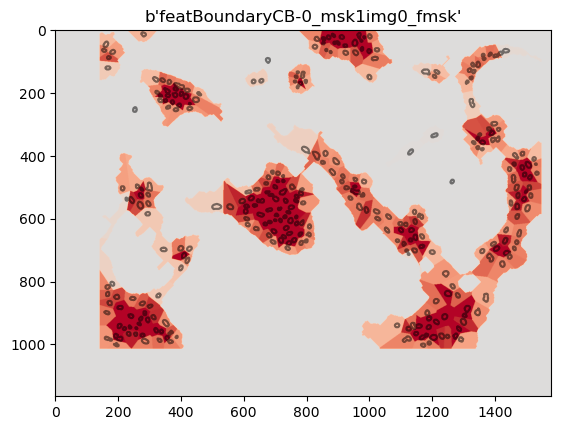

In [3]:
iframe=100 #just looking at features from a random model (movie) and frame to see what it looks like
h5filename=modelList[2]
sctm=trajectory.Trajectory(h5filename=h5filename,data_list=['cell_data_m0','cell_data_m1']) #useful for restarting a calculation to grab new features
msk=sctm.get_mask_data(iframe)
fmsk=sctm.get_fmask_data(iframe)
indframe=np.where(sctm.cells_frameSet==iframe)[0]
cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
nuc_img_channel=np.where(sctm.channels==np.array(['nuc']).astype('S32'))[0][0]
rep_img_channel=np.where(sctm.channels==np.array(['rep']).astype('S32'))[0][0]
bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
ifeat=np.where(sctm.Xf_feature_list==b'featBoundaryCB-0_msk1img0_fmsk')[0][0] #this corresponds roughly to the fraction of the cell boundary in contact with other cells
#ifeat=np.where(sctm.Xf_feature_list==b'featBoundary-1_msk0img0')[0][0]
plt.contour(msk[...,nuc_msk_channel]>0,colors='black',alpha=.5)
fmap=imprep.get_feature_map(sctm.Xf[indframe,ifeat],msk[...,cyto_msk_channel])
#plt.contour(fmsk,colors='black',alpha=.5)
plt.imshow(fmap,cmap=plt.cm.coolwarm,clim=(-np.nanmax(fmap),np.nanmax(fmap)))
plt.title(sctm.Xf_feature_list[ifeat])
sctm.mask_channels

## Batch Loading and Verification of Model Data

This section of the notebook automates the loading of multiple trajectory models from HDF5 files and verifies the presence of necessary data attributes such as masks, channels, and features. This systematic validation ensures that each model is ready for subsequent analysis steps.

### Steps:

1. **Initialization**: Define a list to store each loaded model and an array to keep track of models that meet all data requirements.
2. **Model Loading**:
   - Load each model using the `trajectory.Trajectory` class, specifying necessary data lists like `'cell_data_m0'` and `'cell_data_m1'`.
3. **Data Verification**:
   - Verify the existence of essential data channels (`cyto`, `nuc`, etc.) and features (`cellblocks`, `Xf`, motility features).
   - Log the status of each model, noting successful loads and any missing data.
4. **Filter Models**:
   - Identify and store indices of models that have complete data sets, ensuring they are suitable for detailed analysis.


In [4]:
nmodels=len(modelList)
modelSet=[None]*nmodels
indgood_models=np.array([]).astype(int)
for imodel in range(nmodels):
    h5filename=modelList[imodel]
    try:
        modelSet[imodel]=trajectory.Trajectory(h5filename=h5filename,data_list=['cell_data_m0','cell_data_m1'])
        sctm=modelSet[imodel]
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['nuc']).astype('S32'))[0][0]
        rep_img_channel=np.where(sctm.channels==np.array(['rep']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel; sctm.mskchannel=mskchannel
        status=hasattr(modelSet[imodel],f'cellblocks')
        if status:
            print(f'loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
        else:
            print(f'cell info on {mskchannel} not found') 
        if status and hasattr(modelSet[imodel],f'Xf'): #np.sum(np.logical_not(np.isfinite(modelSet[imodel].Xf)))==0:
            print('has morphology features')
            if hasattr(modelSet[imodel],f'm{cyto_msk_channel}_comdx_feat'):
                print('has motility features')
                indgood_models=np.append(indgood_models,imodel)
    except Exception as e:
        print(e)
        pass

loading data/mcf10a_LI204601_2019-04-09_example2024_EGF.h5
interpreting image as xyc
loading data/mcf10a_LI204601_2019-04-09_example2024_EGF.h5:cell_data_m0
loading data/mcf10a_LI204601_2019-04-09_example2024_EGF.h5:cell_data_m1
loaded data/mcf10a_LI204601_2019-04-09_example2024_EGF.h5 with [b'nuc' b'cyto'] mask channels, [b'BF' b'nuc' b'rep'] image channels, cell index on 1
has morphology features
has motility features
loading data/mcf10a_LI204601_2019-04-09_example2024_EGFTGFB.h5
interpreting image as xyc
loading data/mcf10a_LI204601_2019-04-09_example2024_EGFTGFB.h5:cell_data_m0
loading data/mcf10a_LI204601_2019-04-09_example2024_EGFTGFB.h5:cell_data_m1
loaded data/mcf10a_LI204601_2019-04-09_example2024_EGFTGFB.h5 with [b'nuc' b'cyto'] mask channels, [b'BF' b'nuc' b'rep'] image channels, cell index on 1
has morphology features
has motility features
loading data/mcf10a_LI204601_2019-04-09_example2024_OSM.h5
interpreting image as xyc
loading data/mcf10a_LI204601_2019-04-09_example2024

## Feature analysis

### Aggregating Image Features Across Models

After ensuring that our models are correctly loaded with all required data attributes, the next step is to compile image features for further analysis. Features like Zernike polynomials, texture, and shape from multiple datasets are collated into a single matrix, and cleaned for any NaN values.


In [5]:
#image features stored in sctm.Xf, here Zernike polynomials, texture, shape, environment, etc
indkeep_features=np.arange(modelSet[indgood_models[0]].Xf.shape[1]).astype(int)
Xf_feature_list=modelSet[indgood_models[0]].Xf_feature_list[indkeep_features]
nfeat=indkeep_features.size
Xf=np.zeros((0,nfeat))
indtreatment=np.array([]).astype(int)
indcellSet=np.array([]).astype(int)
for i in indgood_models:
    Xf=np.append(Xf,modelSet[i].Xf[:,indkeep_features],axis=0)
    indtreatment=np.append(indtreatment,i*np.ones(modelSet[i].Xf.shape[0]).astype(int))
    indcellSet=np.append(indcellSet,modelSet[i].cells_indSet)

#data cleaning
print(f'There are {np.sum(np.isnan(Xf))} NaNs of {Xf.size} values, replacing with zero here.')
Xf[np.isnan(Xf)]=0.0

There are 6216 NaNs of 34693660 values, replacing with zero here.


#### Principal Component Analysis of Image Features

In this section, we perform Principal Component Analysis (PCA) on the z-normalized image features to reduce dimensionality and to uncover the major variance components across the datasets. PCA loadings are plotted to understand the contribution of each feature to the PCs, and we make a scatter plot of the first two principal components to visualize the data distribution and to observe any clustering by treatment condition at this stage.

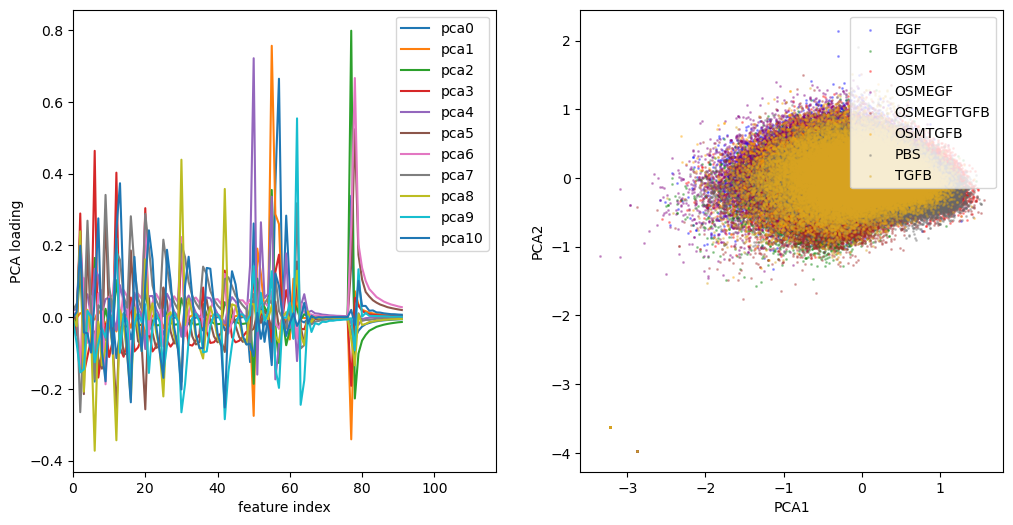

In [6]:
#PCA of image features
Xpca,pca=features.get_pca_fromdata(Xf,var_cutoff=.9); pca.ndim=Xpca.shape[1]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for ipca in range(pca.n_components_):
    plt.plot(pca.components_[ipca,:],label=f'pca{ipca}')

plt.ylabel('PCA loading')
plt.xlabel('feature index')
plt.legend(loc='upper right')
plt.xlim(0,Xf.shape[1]+25)

plt.subplot(1,2,2)
for i_tm in range(len(tmSet)):
    inds=np.where(indtreatment==i_tm)[0]
    plt.scatter(Xpca[inds,0],Xpca[inds,1],s=5,label=tmSet[i_tm],color=colorSet[i_tm],alpha=.3,marker='.')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(loc='upper right')
plt.pause(.1)

#### Motility Feature Extraction and Normalization

Collect precalculated motility features which include measurements of cell speed, directional alignment (beta), and on-axis anti-alignment (alpha), see [get_motility_features](https://jcopperm.github.io/celltraj/api.html#celltraj.trajectory.Trajectory.get_motility_features), and z-normalize.


In [7]:
#motility features
nfeat_com=3
com_feature_list=np.array(['speed','beta','alpha']).astype('S32')
Xf_com=np.zeros((0,nfeat_com))
for i in indgood_models:
    Xf_com=np.append(modelSet[i].m1_comdx_feat,Xf_com,axis=0)

for icom in range(Xf_com.shape[1]): #z-norm all of motility features
    Xf_com[:,icom]=imprep.znorm(Xf_com[:,icom])

#### Combining PCA Features with Motility Features

After normalizing and extracting principal components from image features and motility features separately, the next step is to combine these features into a single feature vector. This unified feature vector is assigned back to the models and used for subsequent analysis steps.


In [8]:
#put the features for embedding into Xpca feature vector
feature_list=[]
for i in range(pca.ndim):
    feature_list.append(f'pca{i}')

Xpca=np.concatenate((Xpca,Xf_com),axis=1)
for i in range(len(com_feature_list)):
    feature_list.append(com_feature_list[i].decode())

for i in indgood_models:
   indsf=np.where(indtreatment==i)[0]
   modelSet[i].Xpca=Xpca[indsf,:]

print(feature_list)

['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'speed', 'beta', 'alpha']


## Application of Morphodynamical Trajectory Embedding

### Overview

Time-lapse imaging offers a unique window into the dynamic processes of cells, capturing changes in morphology, motility, and other phenotypic traits over time. Traditional methods often analyze these changes using single snapshots, which can miss the subtleties of cellular dynamics. To overcome this limitation, we apply "trajectory embedding" to analyze morphological feature trajectories across multiple time points. This method enables a more nuanced understanding of cellular behavior by considering the history of morphological changes, rather than isolated instances.

### Methodology

1. **Trajectory Embedding**:
   - Instead of analyzing individual snapshots, we construct trajectories of morphological features over time for each cell. This involves tracking each cell across frames and recording its morphological features at each time point.

2. **Construction of Cell State Landscape**:
   - By embedding the trajectories of cellular features into a lower-dimensional space, we can visualize and analyze the landscape of cell states. This landscape helps reveal how different treatments influence cell behavior and drive transitions between states.

#### Single-cell trajectory extraction
To compute and record the paths of individual cells throughout the duration of the experiment, apply the [get_unique_trajectories](https://jcopperm.github.io/celltraj/api.html#celltraj.trajectory.Trajectory.get_unique_trajectories) method.

The output, `sctm.trajectories`, is a list where each entry represents a unique trajectory. Each trajectory is a sequence of cell indices that traces the path of an individual cell from its first appearance to its last within the dataset.

In [9]:
#Map all trajectories
all_trajSet=[None]*nmodels
for i in indgood_models:
    print(f'mapping trajectories from model {indgood_models[i]} treatment {tmSet[inds_tmSet_models[indgood_models[i]]]}')
    modelSet[i].get_unique_trajectories()
    all_trajSet[i]=modelSet[i].trajectories.copy()

mapping trajectories from model 0 treatment EGF
tracked cell 59607, 2 tracks, 59400 left
tracked cell 59380, 1 tracks, 58300 left
tracked cell 59288, 1 tracks, 57900 left
tracked cell 59240, 1 tracks, 57600 left
tracked cell 59173, 28 tracks, 57300 left
tracked cell 58826, 31 tracks, 55300 left
tracked cell 58696, 17 tracks, 53300 left
tracked cell 58636, 13 tracks, 52200 left
tracked cell 58512, 26 tracks, 49800 left
tracked cell 54861, 2 tracks, 46600 left
tracked cell 50832, 10 tracks, 45600 left
tracked cell 47827, 1 tracks, 45200 left
tracked cell 46668, 2 tracks, 44900 left
tracked cell 46321, 1 tracks, 44600 left
tracked cell 46286, 1 tracks, 44400 left
tracked cell 46032, 1 tracks, 43500 left
tracked cell 46005, 3 tracks, 43300 left
tracked cell 45704, 3 tracks, 41400 left
tracked cell 44463, 4 tracks, 39500 left
tracked cell 44359, 3 tracks, 39100 left
tracked cell 44185, 24 tracks, 38000 left
tracked cell 43285, 14 tracks, 37600 left
tracked cell 42690, 21 tracks, 36700 left


#### Time-Correlation Function Analysis

To optimize the use of trajectory embedding in capturing dynamic cell behavior, we compute the time-correlation function (TCF) for the PCA-transformed features. The TCF helps determine the temporal window in which the features maintain useful correlations, increasing the information from the single-cell snapshot features for the trajectory embedding methodology.

#### Purpose

- **Identify Temporal Correlations**: By calculating the TCF, we can identify the time intervals over which the feature correlations decay toward zero. This decay indicates the typical timescale over which past information remains relevant to the cell's current state.

#### Methodology

- **TCF Calculation**: For each model corresponding to different treatment conditions, the TCF is calculated from the PCA features.
- **Visualization**: The TCFs are plotted against time separation to visually assess the decay of feature correlations over time.


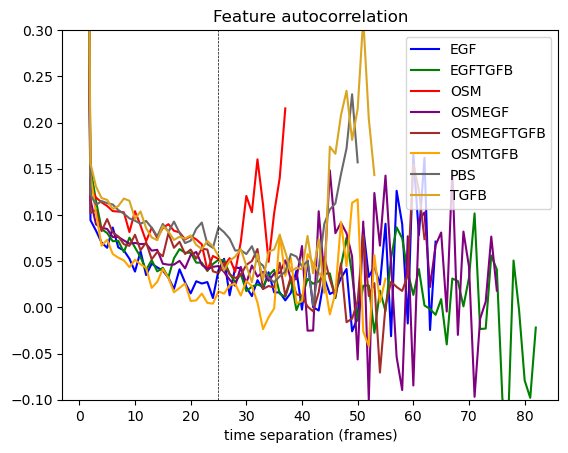

In [25]:
tcfSet=[None]*nmodels
for imodel in indgood_models:
    sctm=modelSet[imodel]
    tcf=sctm.get_tcf(x=sctm.Xpca,minlength=1)
    av_sq=np.sum(np.power(np.nanmean(sctm.Xpca,axis=0),2))
    avsq=np.nanmean(np.power(np.linalg.norm(sctm.Xpca,axis=1),2))
    tcf=(tcf-av_sq)/tcf[0] #auto-correlation
    tcfSet[imodel]=tcf
    plt.plot(np.arange(1,tcf.size+1),tcf,color=colorSet[inds_tmSet_models[indgood_models[imodel]]],label=tmSet[inds_tmSet_models[indgood_models[imodel]]])

plt.plot([25,25],[-.1,.3],'k--',linewidth=.5)
plt.ylim(-.1,.3)
plt.title('Feature autocorrelation');plt.xlabel('time separation (frames)');plt.legend(loc='upper right')

### Trajectory Embedding for Enhanced Analysis

In this section, we assemble the trajectory embedded to data.

#### Purpose

- **Trajectory Construction**: Assembles trajectories from sequences of PCA-transformed feature data, tracking changes in cell state over time.
- **Dimensionality Expansion**: Each trajectory concatenates multiple timepoints to form a higher-dimensional representation of cell behavior.

#### Methodology

- **Trajectory Length**: We define the trajectory length, which determines how many consecutive frames are considered for each trajectory.
- **Feature Concatenation**: PCA features from consecutive frames are concatenated to form a single trajectory vector.
- **Data Selection**: Trajectories containing NaN values are filtered out to ensure quality and consistency in the analysis.


In [10]:
#trajectory embedding
trajl=25 #chose 25 frames as the trajectory length, roughly where time-correlations decay towards zero.
ind_cb=np.where(Xf_feature_list==b'featBoundaryCB-0_msk1img0_fmsk')[0][0]
pca.ndim=modelSet[indgood_models[0]].Xpca.shape[1]
Xpcat=np.zeros((0,pca.ndim*trajl))
indtreatment_traj=np.array([]).astype(int)
indstack_traj=np.array([]).astype(int)
indframes_traj=np.array([]).astype(int)
cellinds0_traj=np.array([]).astype(int)
cellinds1_traj=np.array([]).astype(int)
cb_ratio_traj=np.array([])
cb_ratio_full_traj=np.zeros((0,trajl))
dx_full_traj=np.zeros((0,trajl))
dx_traj=np.array([])
beta_traj=np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories=all_trajSet[i].copy()
    modelSet[i].trajl=trajl
    modelSet[i].traj=modelSet[i].get_traj_segments(trajl)
    data=modelSet[i].Xpca[modelSet[i].traj,:]
    data=data.reshape(modelSet[i].traj.shape[0],modelSet[i].Xpca.shape[1]*trajl)
    indgood=np.where(np.sum(np.isnan(data),axis=1)==0)[0]
    data=data[indgood,:]
    modelSet[i].traj=modelSet[i].traj[indgood,:]
    Xpcat=np.append(Xpcat,data,axis=0)
    indtreatment_traj=np.append(indtreatment_traj,i*np.ones(data.shape[0]).astype(int))
    indstacks=modelSet[i].cells_imgfileSet[modelSet[i].traj[:,0]]
    indstack_traj=np.append(indstack_traj,indstacks)
    indframes=modelSet[i].cells_frameSet[modelSet[i].traj[:,-1]]
    indframes_traj=np.append(indframes_traj,indframes)
    cellinds0=modelSet[i].traj[:,0]
    cellinds0_traj=np.append(cellinds0_traj,cellinds0)
    cellinds1=modelSet[i].traj[:,-1]
    cellinds1_traj=np.append(cellinds1_traj,cellinds1)
    cb_ratio_traj=np.append(cb_ratio_traj,modelSet[i].Xf[cellinds1,ind_cb])
    cb_ratio_full_traj=np.append(cb_ratio_full_traj,modelSet[i].Xf[modelSet[i].traj,ind_cb],axis=0)
    dx_traj=np.append(dx_traj,modelSet[i].m1_comdx_feat[cellinds1,0])
    beta_traj=np.append(beta_traj,modelSet[i].m1_comdx_feat[cellinds1,1])
    dx_full_traj=np.append(dx_full_traj,modelSet[i].m1_comdx_feat[modelSet[i].traj,0],axis=0)

cellinds0_traj=cellinds0_traj.astype(int)
cellinds1_traj=cellinds1_traj.astype(int)

building trajectory data for model 0...
building trajectory data for model 1...
building trajectory data for model 2...
building trajectory data for model 3...
building trajectory data for model 4...
building trajectory data for model 5...
building trajectory data for model 6...
building trajectory data for model 7...


#### Analysis Setup for Condition-Specific Trajectory Embedding

In this section, we configure the data for a treatment-specific analysis of embedded trajectories. Indices are created for each condition to facilitate easy access and manipulation during analysis.

In [11]:
x=Xpcat #trajectory-embedded feature vector
for i in indgood_models:
    modelSet[i].trajectories=all_trajSet[i].copy()

neigen=x.shape[1]
inds_conditions=[None]*nf
for imf in range(nf):
    indmodels=np.intersect1d(indgood_models,np.where(inds_tmSet_models==imf)[0])
    indstm=np.array([])
    for imodel in indmodels:
        indtm=np.where(indtreatment_traj==imodel)
        indstm=np.append(indstm,indtm)
    inds_conditions[imf]=indstm.astype(int).copy()

neigen=x.shape[1]
inds_conditions=[None]*nf
for imf in range(nf):
    indmodels=np.intersect1d(indgood_models,np.where(inds_tmSet_models==imf)[0])
    indstm=np.array([])
    for imodel in indmodels:
        indtm=np.where(indtreatment_traj==imodel)
        indstm=np.append(indstm,indtm)
    inds_conditions[imf]=indstm.astype(int).copy()

#### Extracting Transitions in the Trajectory Embedding Space

##### Purpose
This section focuses on extracting and analyzing transitions between states in the trajectory embedding space. By examining these transitions, we can uncover the dynamics of cell behavior across conditions and time points.

##### Methodology
- **Data Preparation**: Initialize arrays to store the starting and ending points of transitions (`x0set` and `x1set`).
- **Loop through Models**: For each model corresponding to a treatment or condition, perform the following:
  1. **Adjust Indices**: Adjust the trajectory indices to match the model-specific data slice.
  2. **Extract Transitions**: Utilize the `get_trajectory_steps` function to determine the initial and final states of each trajectory segment within the model.
  3. **Aggregate Transitions**: Collect all starting and ending points across all models to analyze transitions globally.


In [12]:
#get transitions in the trajectory embedding space
x0set=np.zeros((0,neigen))
x1set=np.zeros((0,neigen))
inds_trajsteps_models=np.array([]).astype(int)
inds_trajsteps=np.zeros((0,2)).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm=np.where(indtreatment_traj==i)[0]
    if indstm.size>0:
        modelSet[i].Xtraj=x[indstm,0:neigen]
        indstm_model=indstm-np.min(indstm) #index in model
        modelSet[i].get_trajectory_steps(inds=None,get_trajectories=False,traj=modelSet[i].traj[indstm_model,:],Xtraj=modelSet[i].Xtraj[indstm_model,:])
        x0=modelSet[i].Xtraj0
        x1=modelSet[i].Xtraj1
        x0set=np.append(x0set,x0,axis=0)
        x1set=np.append(x1set,x1,axis=0)
        inds_trajsteps_models=np.append(inds_trajsteps_models,np.ones(x0.shape[0]).astype(int)*i)
        inds_trajsteps=np.append(inds_trajsteps,modelSet[i].inds_trajp1,axis=0)

getting flows from model: 0
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
matching up trajectory 2800
matching up trajectory 2900
matching up trajectory 3000
matching up trajectory 3100
matching up trajectory 3200
matching up trajectory 3300
matching up trajectory 3400
matc

## Data-Driven Modeling: Microstate Analysis and Markov State Models (MSM)
In this section, we employ a rigorous, data-driven approach to model cellular dynamics using k-means clustering and Markov State Models (MSM). This methodology helps dissect complex cellular behaviors into quantifiable and analyzable components, enhancing our understanding of cellular dynamics under different microenvironmental conditions.

#### Methodology Overview:
1. **Microstate Definition:**

Utilizing k-means clustering, we partition high-dimensional trajectory data into discrete microstates, each representing similar cellular behaviors based on morphological features.

2. **Markov State Model (MSM) Construction:**

We construct an MSM to model transitions between these microstates over time, quantifying transition probabilities with a state transition matrix.

3. **Kinetic Analysis via Eigendecomposition:**

Eigendecomposition of the transition matrix reveals dominant kinetic components, identifying significant temporal behaviors and stability within the cellular state landscape.

4. **Embedding and Visualization:**

The extracted eigenvectors are used to embed and visualize cell trajectories, illustrating transitions and dynamical changes across different states and conditions.

#### Key Insights:
- Systematic Characterization: This framework allows for a systematic and quantitative characterization of cell behavior dynamics.
- Behavioral Landscapes: Kinetic analysis helps identify stable and transient states and their dependency on external conditions.
- Predictive Modeling: MSM provides a foundation for predictive simulations of cellular responses and state dynamics.








##### Microstate Clustering

To dissect and analyze the high-dimensional cellular data into manageable and interpretable units, we utilize k-means clustering to define microstates. 

- **Initialization**: We deploy the `KMeans` clustering algorithm from the `sklearn.cluster` library.

- **Assignment of Centers**: Post clustering, the centers identified by `sklearn`'s KMeans are utilized to create an instance of `AssignCenters` from `coor.clustering`, which facilitates compatibility with the `celltraj.model` tools.


In [13]:
#get microstate clusters
n_clusters=150
clusters_sklearn=sklearn.cluster.KMeans(n_clusters=n_clusters,init='k-means++',n_init=10,max_iter=1000,random_state=0)
clusters_sklearn.fit(x)
clusters=coor.clustering.AssignCenters(clusters_sklearn.cluster_centers_, metric='euclidean') #for back-compatibility with celltraj.model tools

#### Construction and Analysis of the Markov State Model (MSM)

After defining microstates through clustering, we proceed to construct a Markov State Model (MSM) to examine the dynamics between these states.

##### Building the Transition Matrix:
- **Transition Matrix (`P`)**: We calculate the transition probabilities between microstates from the `x0set` to `x1set` using the `get_transition_matrix` function. This function utilizes the microstate centers from the cleaned clusters as the basis for transition probability computation.

##### Cleaning the Clusters:
- We clean the initial clusters to remove weakly connected components, ensuring a more robust MSM. This is done using the `clean_clusters` function which also refines the cluster centers (`centers_minima`) based on the transition matrix.

##### MSM Analysis:
- **Hermitian Matrix (`H`)**: We construct the Hermitian form of the transition matrix to facilitate the extraction of real eigenvalues, which represent the system's dynamics. The matrix `H` is defined as:
  \[
  H = 0.5 \times (P + P^T) + 0.5i \times (P - P^T)
  \]
  This formulation allows us to capture both the forward and reverse dynamics symmetrically.

- **Eigendecomposition**: We perform an eigendecomposition of `H` to identify the principal modes of the dynamics. The real parts of the eigenvalues (`w`) are sorted and plotted, which highlight the dominant kinetic processes.

##### Visualization:
- A plot of the eigenvalues of `H` provides insights into the stability and timescales of the processes captured by the MSM. We will use the eigenvalue plot to identify the top eigenmodes, identified by seeking the elbow in the eigenvalue spectrum.


In [14]:
#Markov state model
centers_minima=clusters.clustercenters.copy()
clusters_minima=coor.clustering.AssignCenters(centers_minima, metric='euclidean')
P=model.get_transition_matrix(x0set,x1set,clusters=clusters_minima)
indcc,clusters_minima=model.clean_clusters(clusters,P)
centers_minima=centers_minima[indcc,:];stateCenters=centers_minima
clusters_minima=coor.clustering.AssignCenters(centers_minima, metric='euclidean')
P=model.get_transition_matrix(x0set,x1set,clusters=clusters_minima)
n_clusters=indcc.size

H=.5*(P+np.transpose(P))+.5j*(P-np.transpose(P))
w,v=np.linalg.eig(H)
w=np.real(w)
indsort=np.argsort(w)
w=w[indsort]
v=v[:,indsort]

plt.clf()
plt.plot(np.arange(n_clusters),w,'ko',label='eigenvalues')
plt.ylim(0,np.max(w)+.05*np.max(w))
plt.xlabel('eig index')
plt.ylabel('H eigenvalue')

Text(0, 0.5, 'H eigenvalue')

##### Visualize the significant eigenvalues to identify kinetic modes, and construct kinetic motifs `vkin`.


In [15]:
ncomp=16 #number of eigencomponents to keep
vr=np.multiply(w[-ncomp:],np.real(v[:,-ncomp:]))
vi=np.multiply(w[-ncomp:],np.imag(v[:,-ncomp:]))
vkin=np.append(vr,vi,axis=1)
va=np.abs(v[:,-ncomp:])
vkin=np.append(vr,vi,axis=1)
vth=np.arctan2(vr,vi)
plt.clf()
plt.plot(np.arange(n_clusters),w,'ko',label='eigenvalues')
#plt.plot(dense_range,wdense,'k-',label='spline')
plt.plot(np.arange(n_clusters)[-ncomp:],w[-ncomp:],'ro')
plt.ylim(0,np.max(w)+.05*np.max(w))
plt.xlabel('eig index')
plt.ylabel('H eigenvalue')

Text(0, 0.5, 'H eigenvalue')

#### UMAP Embedding of Kinetic Motif Space
This visualization helps to explore the underlying structure of the cell state dynamics more intuitively.

In [16]:
#make UMAP of kinetic motif space
reducer=umap.UMAP(n_components=2)
trans = reducer.fit(vkin)
x_clusters=trans.embedding_
ind_clusters=clusters_minima.assign(x)
x_clusters_all=x_clusters[ind_clusters,:]

#### Visualizing Kinetic Motifs in UMAP Space

Visualize the transformed kinetic motifs in the UMAP space, focusing on both the absolute values and angles (theta) of the components. This visualization helps in understanding the `vkin` kinetic signatures which will be used for clustering into morphodynamical cell states.

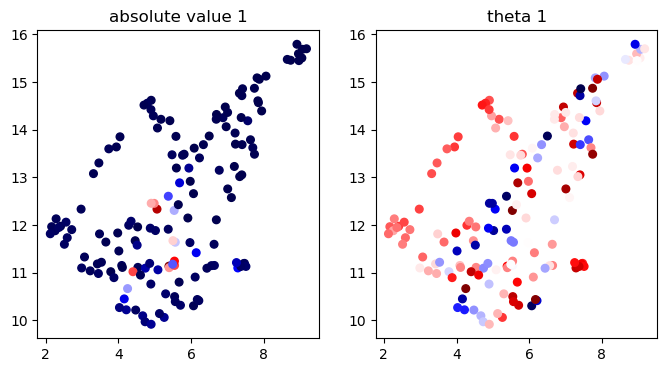

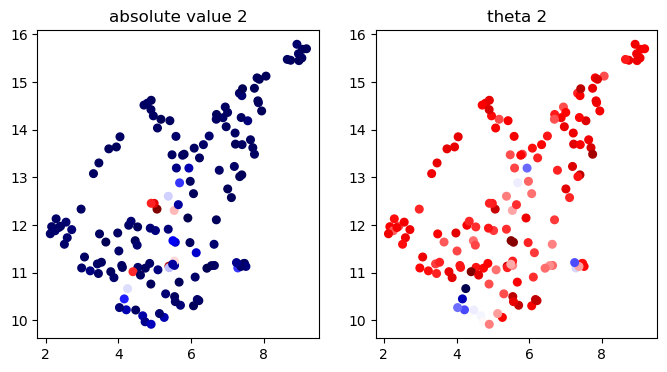

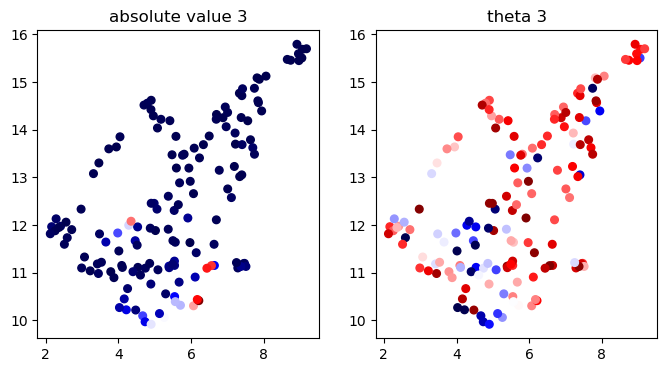

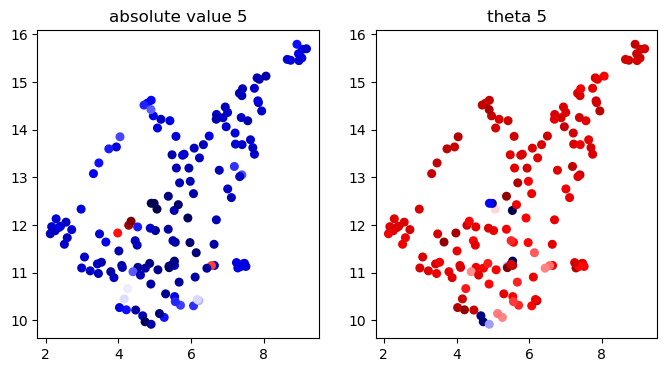

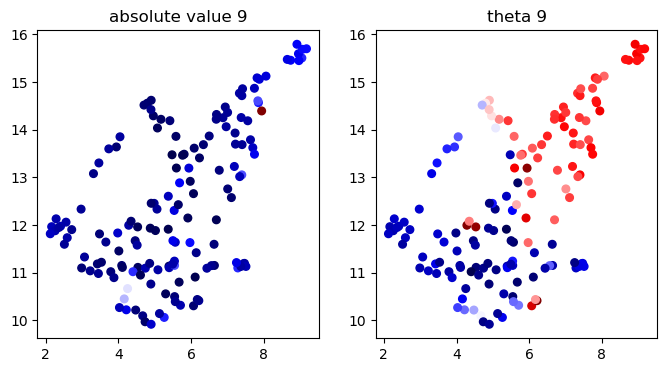

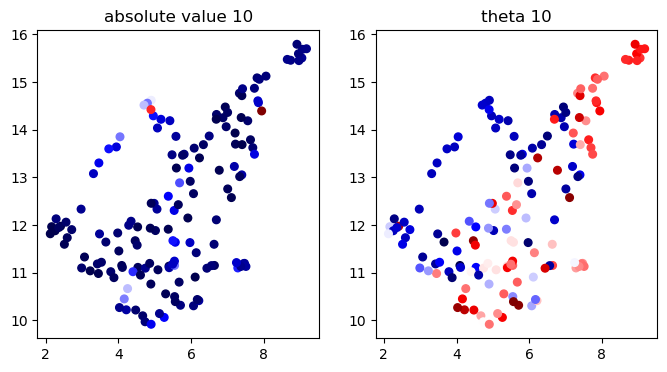

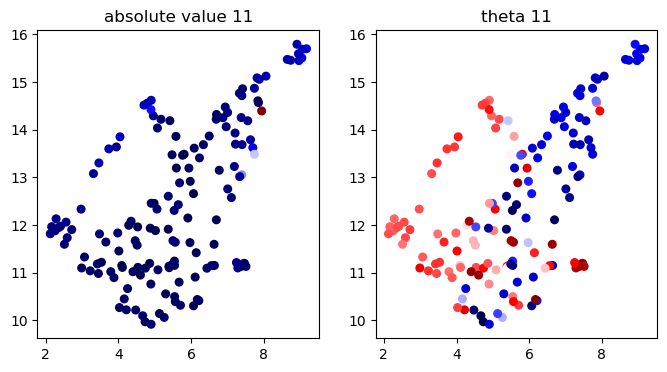

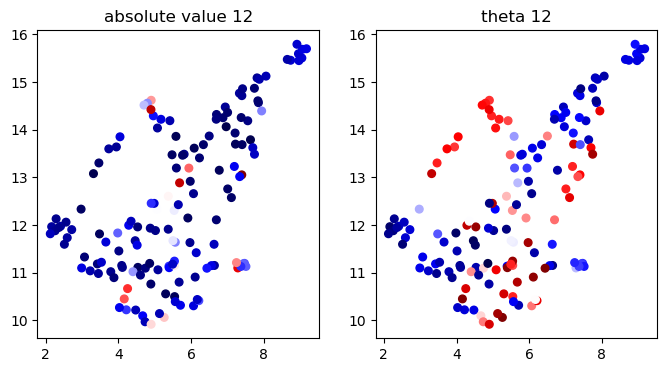

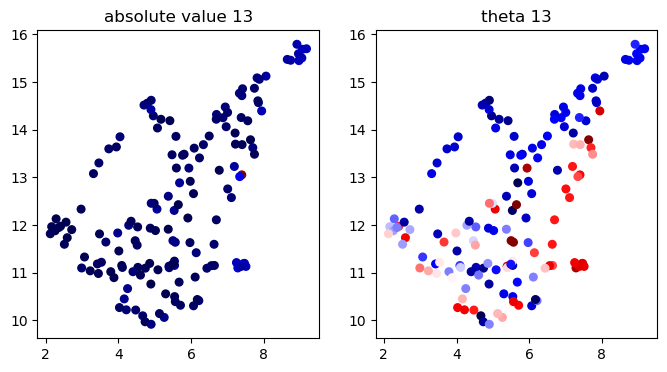

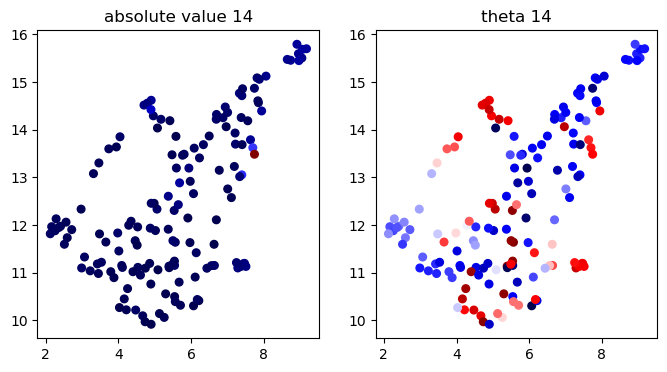

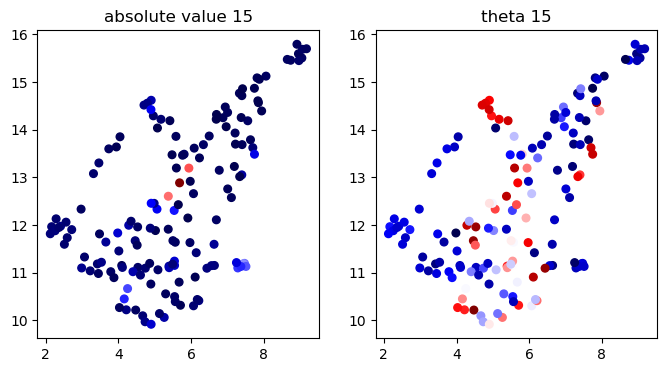

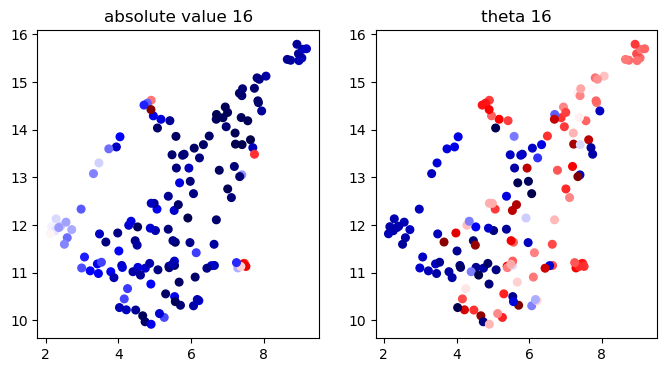

In [17]:
for icomp in range(ncomp-1,0-1,-1): #range(ncomp):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1);plt.scatter(x_clusters[:,0],x_clusters[:,1],s=30,c=va[:,icomp],cmap=plt.cm.seismic)
    plt.title(f'absolute value {ncomp-icomp}')
    plt.subplot(1,2,2);plt.scatter(x_clusters[:,0],x_clusters[:,1],s=30,c=vth[:,icomp],cmap=plt.cm.seismic)
    plt.title(f'theta {ncomp-icomp}')

#### Calculating and Smoothing Directional Fluxes Across Treatments

Compute the directional fluxes of cell states across different treatments. The directional fluxes are derived from the transition matrices between states and are helpful for understanding the overall dynamics in the landscape, and how treatments influence the dynamics of state transitions. The smoothing step helps to mitigate noise and reveal more robust patterns in the directional data.

(1.7720206876636384, 9.531882242109667, 9.581985612955993, 16.08870327408411)

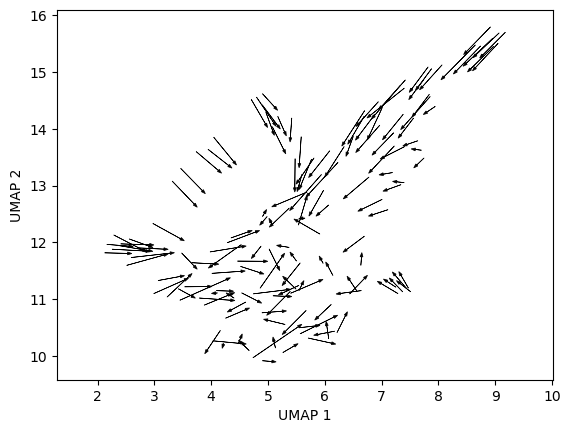

In [18]:
dx_clusters=np.zeros((nf,n_clusters,2))
MtSet=[None]*nf
for i in range(nf):
    indmodels=np.where(inds_tmSet_models==i)[0]
    indstm=np.array([]).astype(int)
    for imodel in indmodels:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==imodel)[0].astype(int))
    x0=x0set[indstm,:]
    x1=x1set[indstm,:]
    Mt=model.get_transition_matrix(x0,x1,clusters_minima)
    MtSet[i]=Mt.copy()
    dxmatrix=np.zeros((n_clusters,n_clusters,2))
    for ii in range(n_clusters):
        for jj in range(n_clusters):
            dxmatrix[ii,jj]=(x_clusters[jj,:]-x_clusters[ii,:])*Mt[ii,jj]
    dx_clusters[i,:,:]=np.sum(dxmatrix,axis=1)

dx_clusters_smooth=np.zeros_like(dx_clusters)
knn=10
for i in range(nf):
    for iclust in range(n_clusters):
        xc=np.array([clusters_minima.clustercenters[iclust,:]])
        dmatr=utilities.get_dmat(clusters_minima.clustercenters,xc) #get closest cells to cluster center
        indr=np.argsort(dmatr[:,0])
        indr=indr[0:knn]
        dx_clusters_smooth[i,iclust,:]=np.mean(dx_clusters[i,indr,:],axis=0)

dxsav=np.mean(dx_clusters_smooth,axis=0)
ascale=1.0
ax=plt.gca()
for ic in range(n_clusters):
    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],ascale*dxsav[ic,0],ascale*dxsav[ic,1],head_width=.05,linewidth=.5,color='black',alpha=1.0)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('equal')

### Morphodynamical distributions and flows by treatment
  - Cumulative distributions are computed from 2D histograms of trajectory embeddings in a reduced space (e.g., UMAP), smoothed with a Gaussian filter for better visual clarity.
  - Arrows are plotted to indicate the direction and magnitude of state transitions, helping visualize the dynamic flow of cell states.
  - These plots compare how distinct treatments affect cell state distributions and transitions, with each subplot showing the cumulative distribution of trajectories specific to that treatment.

Visualization of these cumulative distributions and transition flows provides insight into cell dynamics under different experimental conditions.

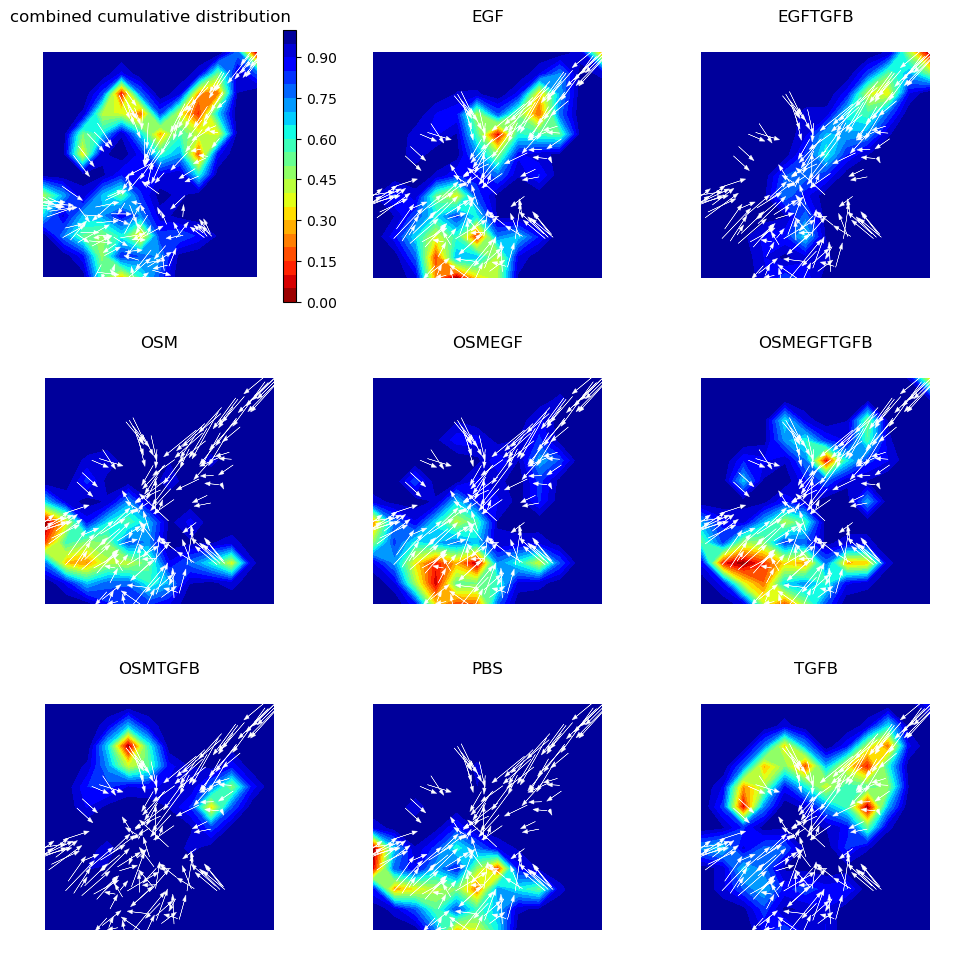

In [19]:
plt.close('all')
nbins=12
fl=128
fu=192 #frames for time window
sml=.5
nplots=int(np.ceil(np.sqrt(nf+1)))
plt.figure(figsize=(12,12))
indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
probSet=[None]*nf
plt.subplot(nplots,nplots,1)
prob1,xedges1,yedges1=np.histogram2d(x_clusters_all[indstw,0],x_clusters_all[indstw,1],bins=nbins,density=True)
prob1=scipy.ndimage.gaussian_filter(prob1,sigma=sml)
prob1c=utilities.get_cdist2d(prob1)
xx,yy=np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1],.5*yedges1[1:]+.5*yedges1[0:-1])
levels=np.linspace(0,1,21)
cs=plt.contourf(xx,yy,prob1c.T,levels=levels,cmap=plt.cm.jet_r)
cbar=utilities.colorbar(cs)
#cbar.set_label('cumulative probability')
plt.title('combined cumulative distribution')
plt.axis('off')
for ic in range(n_clusters):
    ax=plt.gca()
    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],dxsav[ic,0],dxsav[ic,1],head_width=.1,linewidth=.3,color='white',alpha=1.0)
    
for imf in range(nf):
    tm=tmSet[imf]
    indstm=inds_conditions[imf]
    indstwm=np.intersect1d(indstm,indstw)
    prob,xedges2,yedges2=np.histogram2d(x_clusters_all[indstwm,0],x_clusters_all[indstwm,1],bins=[xedges1,yedges1],density=True)
    #prob=prob/np.sum(prob)
    prob=scipy.ndimage.gaussian_filter(prob,sigma=sml)
    probc=utilities.get_cdist2d(prob)
    probSet[imf]=prob.copy()
    plt.subplot(nplots,nplots,imf+2)
    #levels=np.linspace(0,np.max(prob),100)
    cs=plt.contourf(xx,yy,probc.T,levels=levels,cmap=plt.cm.jet_r,extend='both')
    dxf=dx_clusters_smooth[i,:,:]
    ax=plt.gca()
    for ic in range(n_clusters):
        ax.arrow(x_clusters[ic,0],x_clusters[ic,1],dxf[ic,0],dxf[ic,1],head_width=.1,linewidth=.3,color='white',alpha=1.0)
    plt.title(tmSet[imf])
    cs.cmap.set_over('darkred')
    plt.axis('off')

### Morphology and Motility Features on the Landscape

In this section of the notebook, we visualize how specific cell morphology and motility features are distributed across the UMAP-embedded landscape of cell states. This analysis helps to uncover the spatial variations in cell behavior characteristics under different treatment conditions.

For each feature in the set (boundary fraction, displacement in pixels or motility speed, and alignment angle),
we encode the distribution of the specific cell feature across the landscape, helping to contextualize how these features vary with respect to the underlying cell states. This method provides a powerful tool for exploring the complex dynamics of cellular behavior in a condensed and interpretable form.

The landscape derived separates isolated cells with high motility and low motility alignment (enriched under EGF+TGFB) from dense cell clusters with lower overall motility speed and high motility alignment (enriched in OSM).


/tmp/ipykernel_1138/1213011911.py:14: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


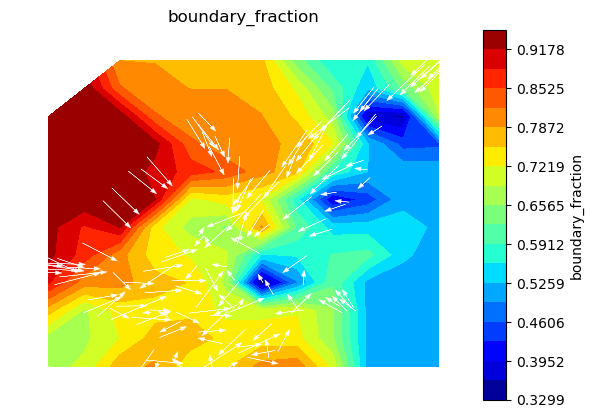

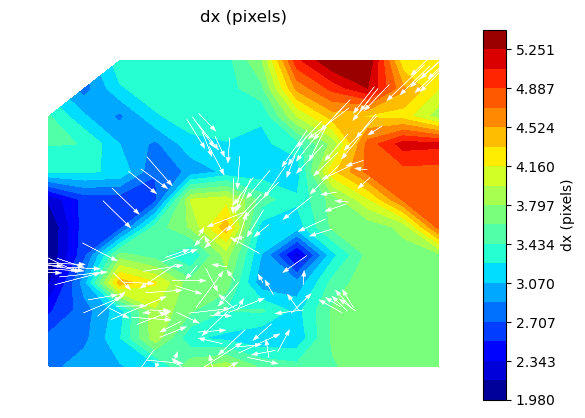

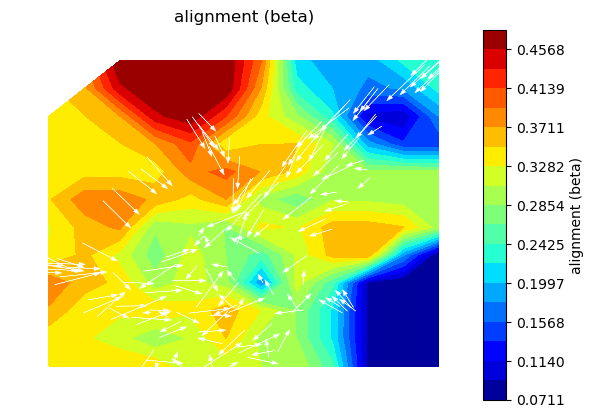

In [20]:
vsetList=[cb_ratio_traj,dx_traj,beta_traj]
captionset=['boundary_fraction','dx (pixels)','alignment (beta)']
nf=len(tmSet)
nbins=12
sml=.5
for iv in range(len(vsetList)):
    vset=vsetList[iv]
    indg=np.where(np.logical_and(np.logical_not(np.isnan(vset)),np.logical_not(np.isinf(vset))))[0]
    plt.figure()
    vdist1,xedges1,yedges1=np.histogram2d(x_clusters_all[indg,0],x_clusters_all[indg,1],bins=nbins,weights=vset[indg])
    vdist1=scipy.ndimage.gaussian_filter(vdist1,sigma=sml)
    norm1,xedges1,yedges1=np.histogram2d(x_clusters_all[indg,0],x_clusters_all[indg,1],bins=[xedges1,yedges1])
    norm1=scipy.ndimage.gaussian_filter(norm1,sigma=sml)
    vdist1=np.divide(vdist1,norm1)
    indnan=np.where(np.isnan(vdist1))
    indgood=np.where(np.logical_and(np.logical_not(np.isnan(vdist1)),np.logical_not(np.isinf(vdist1))))
    xedges1c=.5*(xedges1[1:]+xedges1[0:-1])
    yedges1c=.5*(yedges1[1:]+yedges1[0:-1])
    xx,yy=np.meshgrid(xedges1c,yedges1c)
    levels=np.linspace(np.min(vdist1[indgood]),np.max(vdist1[indgood]),20)
    cs=plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.jet,levels=levels)
    for ic in range(n_clusters):
        ax=plt.gca()
        ax.arrow(x_clusters[ic,0],x_clusters[ic,1],ascale*dxsav[ic,0],ascale*dxsav[ic,1],head_width=.07,linewidth=.3,color='white',alpha=1.0)
    cs.cmap.set_over('darkred')
    cs.cmap.set_under('darkblue')
    cbar=utilities.colorbar(cs)
    cbar.set_label(captionset[iv])
    plt.title(captionset[iv])
    plt.axis('off')

## Defining discrete morphodynamical cell states

### Kinetic Clustering and Evaluation Using Kinetic Scores

In this section, we apply kinetic clustering to our dataset, which involves grouping cells into states based on their dynamics rather than just their static features. The key objective here is to identify clusters that capture the kinetic behavior of cell states within the landscape, using a scoring system that reflects the clusters' dynamical relevance and stability.

#### Methodology

1. **Cluster Initialization**:
   - Initialize a range of cluster counts (`nstateSet`) to evaluate, starting from 2 to 10 potential states.
   - Perform clustering on the kinetic motifs extracted earlier, utilizing K-means clustering initialized with parameters optimized for kinetic data.

2. **Transition Matrix Construction**:
   - For each clustering configuration, compute a transition matrix using the `get_transition_matrix_CG` function. This matrix quantifies the likelihood of transitions between clusters over the observed time steps.

3. **Kinetic Scoring**:
   - Evaluate each cluster configuration using a kinetic score, calculated as the sum of eigenvalues of the transition matrix. This score is based on the variational principle of Markov state models, which posits that good kinetic partitions maximize the sum of the first few dominant eigenvalues.

4. **Iterative Refinement**:
   - Iteratively refine the clustering by increasing the number of states, recalculating transition matrices, and re-evaluating kinetic scores. This iterative approach helps to identify an optimal clustering configuration that balances complexity with dynamical significance.

This kinetic clustering approach allows us to systematically explore how different numbers of clusters (states) impact the dynamical modeling of cell behaviors. By evaluating these models based on kinetic scores, we can select the most appropriate model that captures essential dynamical features without overfitting to noise or irrelevant variations. The resulting clusters provide a basis for further analysis, such as identifying dominant transition pathways or simulating potential interventions in cell dynamics.

[0.00666667 0.99333333]
2 states initial, 1 states final
[0.00666667 0.00666667 0.98666667]
3 states initial, 1 states final
[0.00666667 0.00666667 0.04       0.94666667]
4 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.02666667 0.95333333]
5 states initial, 1 states final
[0.00666667 0.00666667 0.02       0.02       0.02666667 0.92      ]
6 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.02       0.02666667 0.25333333
 0.68      ]
7 states initial, 2 states final
building likelihood model for EGF
building likelihood model for EGFTGFB
building likelihood model for OSM
building likelihood model for OSMEGF
building likelihood model for OSMEGFTGFB
building likelihood model for OSMTGFB
building likelihood model for PBS
building likelihood model for TGFB
2 states
[1.75101129 2.64577778 2.77383524 2.04716981 1.40240964 2.36909122
 1.23295011 2.27049092]


/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


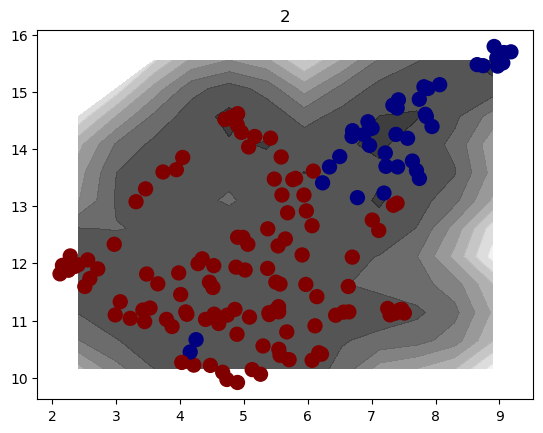

[0.00666667 0.00666667 0.00666667 0.00666667 0.02       0.02
 0.02666667 0.90666667]
8 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.02       0.02
 0.02       0.02666667 0.88666667]
9 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.88      ]
10 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.01333333
 0.02       0.02       0.02666667 0.24666667 0.64      ]
11 states initial, 2 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.05333333 0.07333333 0.75333333]
12 states initial, 3 states final
building likelihood model for EGF
building likelihood model for EGFTGFB
building likelihood model for OSM
building likelihood model for OSMEGF
building likelihood model for OSMEGFTGFB
building likelihood model for OSMTGFB
building likelihood model for PBS
building likelihood model for TGFB


/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


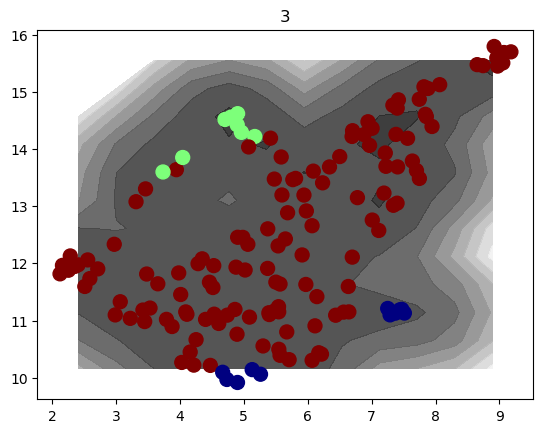

[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.02666667 0.04       0.37333333
 0.44      ]
13 states initial, 2 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.02666667 0.04666667 0.12666667
 0.3        0.38      ]
14 states initial, 3 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02       0.02666667 0.02666667 0.04666667
 0.10666667 0.28       0.4       ]
15 states initial, 3 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.01333333
 0.02       0.02       0.02       0.02       0.02666667 0.02666667
 0.02666667 0.04       0.23333333 0.52      ]
16 states initial, 2 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.01333333 0.02       0.02       0.02       0.02       0.02
 0.02       0.02666667 0.04       0.27333333 0.48666667]
17 states initial, 2 states final
[0.006666

/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


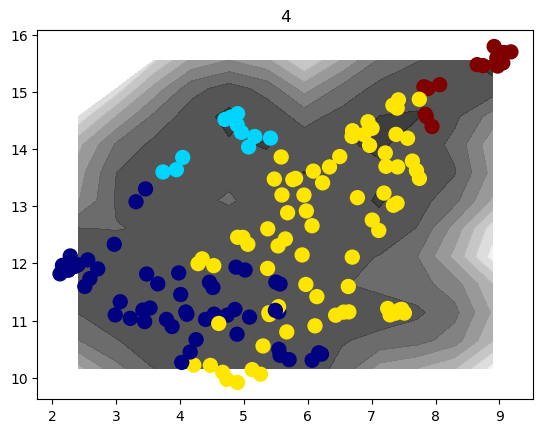

[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.02       0.02666667 0.04       0.04666667
 0.08666667 0.12       0.19333333 0.23333333]
34 states initial, 4 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.02666667 0.02666667
 0.03333333 0.05333333 0.10666667 0.22666667 0.29333333]
35 states initial, 4 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.

/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


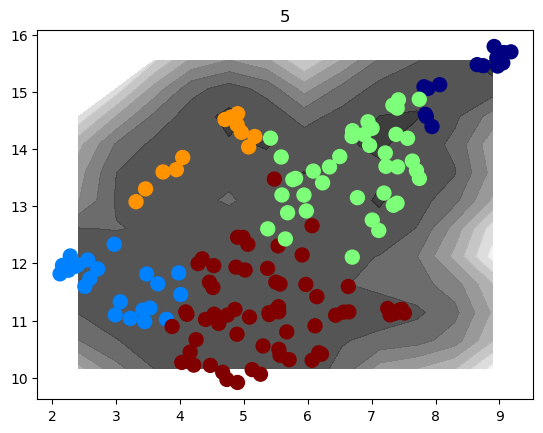

[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.02       0.02666667 0.02666667 0.04666667 0.08666667 0.14666667
 0.15333333 0.24      ]
38 states initial, 4 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.02       0.03333333 0.04       0.08666667
 0.15333333 0.18       0.22      ]
39 states initial, 4 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0

/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


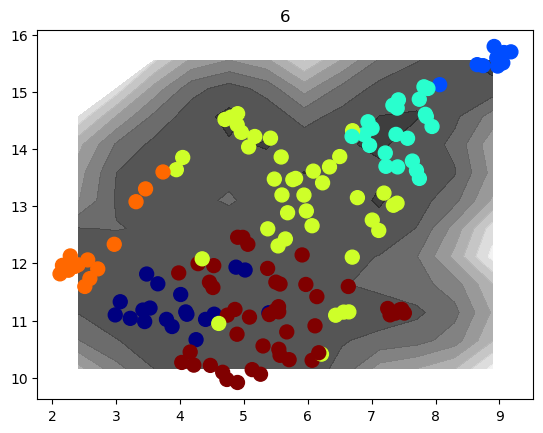

[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.02       0.02666667 0.02666667
 0.03333333 0.04       0.05333333 0.07333333 0.10666667 0.14666667
 0.15333333]
49 states initial, 5 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.00666667
 0.00666667 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.0

/tmp/ipykernel_1138/2130496330.py:31: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)


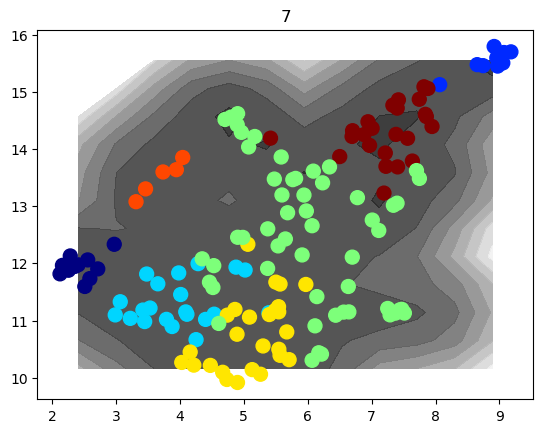

UnboundLocalError: local variable 'state_probs' referenced before assignment

In [21]:
plt.close('all')
plt.clf()
nstateSet=[2,3,4,5,6,7,8,9,10] #,30,40]
nS=len(nstateSet)
scoreSet_states=[None]*nS
nstates_initial=nstateSet[0]
pcut_final=.05
indc_x0set=clusters_minima.assign(x0set);indc_x1set=clusters_minima.assign(x1set)
for istate in range(len(nstateSet)):
    MtSet_test=[None]*nf
    nstates=nstateSet[istate]
    scoreSet=np.zeros(nf)
    #clusters_v = KMeans(n_clusters=nstates,init='k-means++',n_init=1000,max_iter=1000)
    #clusters_v.fit(vkin)
    #states=clusters_v.labels_
    states,nstates_initial=model.get_kineticstates(vkin,nstates,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=True,cluster_ninit=100,max_states=60)
    for imf in range(nf):
        print('building likelihood model for '+tmSet[imf])
        indmodels=np.where(inds_tmSet_models==imf)[0]
        indmodels=np.intersect1d(indmodels,indgood_models)
        indstm=np.array([]).astype(int)
        for i in indmodels: #[:-1]:
            indstm=np.append(indstm,np.where(inds_trajsteps_models==i)[0])
        MtSet_test[imf]=model.get_transition_matrix_CG(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima,states=states)
        scoreSet[imf]=model.get_kscore(MtSet_test[imf])
    print(str(nstates)+' states')
    print(scoreSet)
    nstates_initial=nstates_initial+1
    scoreSet_states[istate]=scoreSet
    plt.clf()
    plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.8)
    plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=states,cmap=plt.cm.jet)
    plt.title(str(nstates))
    plt.pause(2)

#### Plotting kinetic scores and choosing number of states
Here, we lack sufficient trajectory data to construct more than ~8 states. Kinetic scoring suggests that the dynamical description continues to improve with additional states, using the full dataset we found >10 states were needed, see the [manuscript](https://www.biorxiv.org/content/10.1101/2024.01.18.576248v1.abstract).

/tmp/ipykernel_1138/2286486226.py:11: RuntimeWarning: Mean of empty slice
  plt.plot(nstateSet,np.nanmean(scoreSet_statearray,axis=1),'o--',color='black',linewidth=2)


Text(0.5, 0, 'number of states')

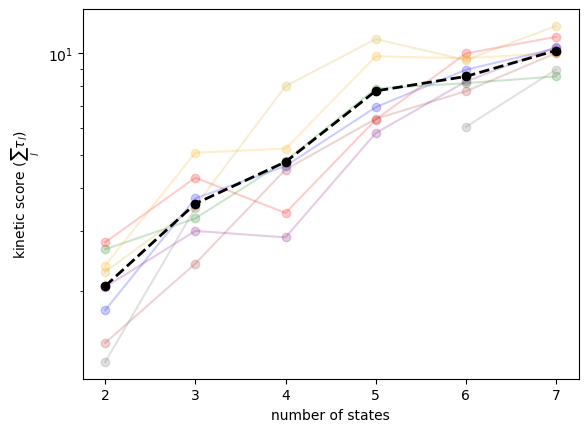

In [22]:
scoreSet_statearray=np.zeros((nS,nf))
for istate in range(len(nstateSet)):
    try:
        scoreSet_statearray[istate,:]=scoreSet_states[istate]
    except:
        pass

for i_tm in range(nf):
    plt.plot(nstateSet,scoreSet_statearray[:,i_tm],'o-',color=colorSet[i_tm],label=tmSet[i_tm],alpha=.2)

plt.plot(nstateSet,np.nanmean(scoreSet_statearray,axis=1),'o--',color='black',linewidth=2)
plt.yscale('log')
plt.ylabel(r'kinetic score ($\sum_l \tau_l$)')
plt.xlabel('number of states')

#### State Selection for Kinetic Modeling

For the current dataset, featuring 8 different treatment conditions, we will employ a leave-one-out cross-validation strategy. Given the requirement to pair live-cell imaging data with molecular measurements and the constraint imposed by the number of treatments, we will model with **7 states**.


In [23]:
get_kstates=True
nstates_final=7
#nstates_final=13 #for production
pcut_final=.05 #for prediction
#pcut_final=.02 #for production
nstates_initial=nstates_final
stateCenters=x_clusters
stateSet=model.get_kineticstates(vkin,nstates_final,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=False,cluster_ninit=100)

nstates=np.unique(stateSet).size; n_states=nstates
state_centers_minima=np.zeros((n_states,2))
for i in range(n_states):
    indstate=np.where(stateSet==i)[0]
    state_centers_minima[i,:]=np.median(stateCenters[indstate,:],axis=0)

state_order=np.argsort(state_centers_minima[:,0])
stateSet_ordered=np.ones_like(stateSet)*-1
for istate in range(nstates):
    stateSet_ordered[stateSet==state_order[istate]]=istate

stateSet=stateSet_ordered

nstates=np.unique(stateSet).size; n_states=nstates
state_centers_minima=np.zeros((n_states,2))
for i in range(n_states):
    indstate=np.where(stateSet==i)[0]
    state_centers_minima[i,:]=np.median(stateCenters[indstate,:],axis=0)

inds_states=[None]*n_states
for i in range(n_states):
    indstate=np.where(stateSet[ind_clusters]==i)[0]
    inds_states[i]=indstate

[0.00666667 0.00666667 0.00666667 0.02       0.02666667 0.25333333
 0.68      ]
7 states initial, 2 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.02       0.02
 0.02666667 0.90666667]
8 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.02       0.02
 0.02       0.02666667 0.88666667]
9 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.88      ]
10 states initial, 1 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.01333333
 0.02       0.02       0.02666667 0.24666667 0.64      ]
11 states initial, 2 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.05333333 0.07333333 0.75333333]
12 states initial, 3 states final
[0.00666667 0.00666667 0.00666667 0.00666667 0.00666667 0.02
 0.02       0.02       0.02666667 0.02666667 0.04       0.37333333
 0.44      ]
13 states initial, 2 states final
[0.

#### Visualize discrete morphodynamical cell states (macrostates) on the landscape

Text(0, 0.5, 'UMAP 2')

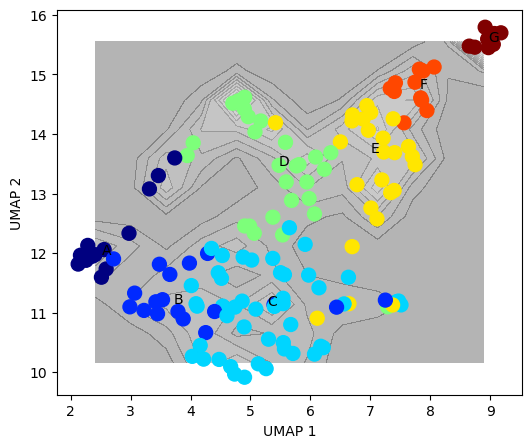

In [24]:
nbins=prob1.shape[0]
state_labels=np.array(list(string.ascii_uppercase))[0:nstates]
plt.close('all');plt.figure(figsize=(6,5))
plt.clf()
pts=np.array([xx.flatten(),yy.flatten()]).T
#indpts=clusters_minima.assign(pts)
#states=stateSet[indpts]
#states=states[prob1.flatten()>np.min(prob1[prob1>0])]
#pts=pts[prob1.flatten()>np.min(prob1[prob1>0]),:]
plt.contourf(xx,yy,prob1.T,cmap=plt.cm.gray,levels=20,alpha=.3)
#plt.scatter(tateSet=model.get_kineticstates(vkin,nstates_final,nstates_initial=nstates_initial,pcut_final=pcut_final,seed=0,return_nstates_initial=False,cluster_ninit=500)ts[:,0],pts[:,1],s=10,c=states,cmap=plt.cm.jet,marker='.',alpha=0.5)
plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=stateSet,cmap=plt.cm.jet)
#for ic in range(n_clusters):
#    ax=plt.gca()
#    ax.arrow(x_clusters[ic,0],x_clusters[ic,1],dxsav[ic,0],dxsav[ic,1],head_width=.1,linewidth=.2,color='white',alpha=1.0)

for istate in range(nstates):
    plt.text(state_centers_minima[istate,0],state_centers_minima[istate,1],str(state_labels[istate]))

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

### Morphology and Motility Features within Morphodynamical Cell States
Here, we visualize the distribution of various morphological and motility features within the discrete morphodynamical cell states using violin plots. These tearplots help us understand how these features vary across different cell states, providing insights into the characteristics and dynamics of each state.

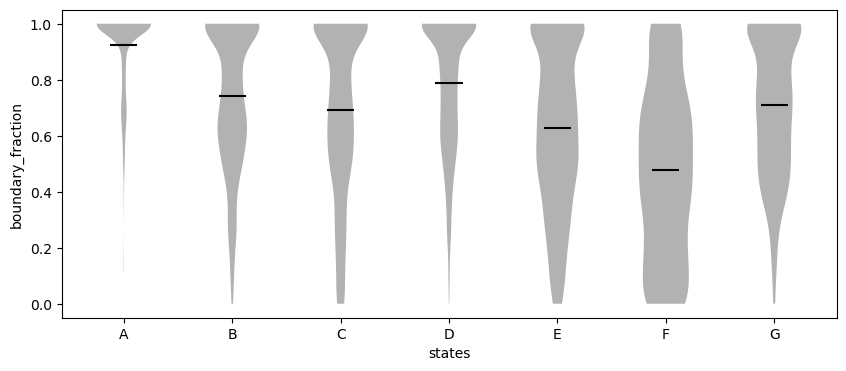

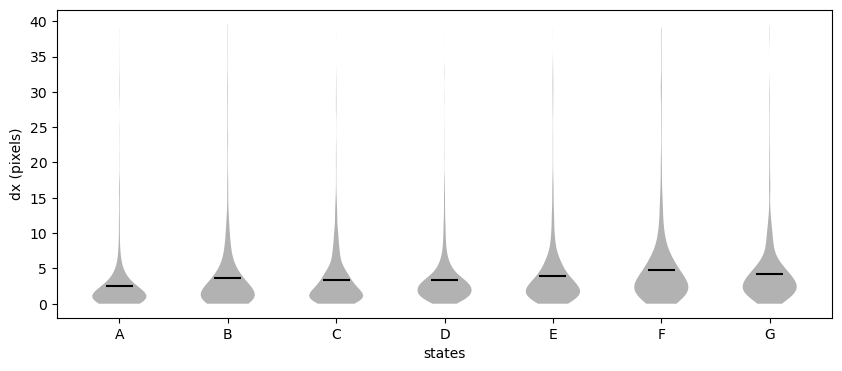

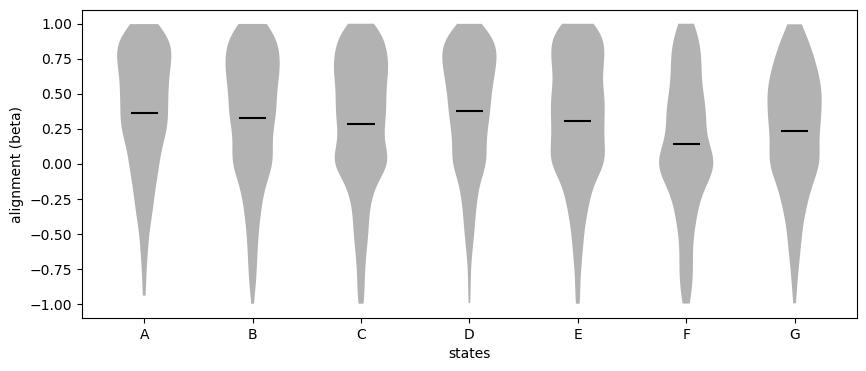

In [25]:
vsetList=[cb_ratio_traj,dx_traj,beta_traj]
captionset=['boundary_fraction','dx (pixels)','alignment (beta)']
for iv in range(len(vsetList)):
    vset=vsetList[iv]
    plt.figure(figsize=(10,4))
    ax=plt.gca()
    for i in range(n_states):
        setv=vset[inds_states[i]]
        setv=setv[np.isfinite(setv)]
        vplot=ax.violinplot(setv,positions=[i+1],showmeans=True,showextrema=False) #,quantiles=[.05,.95])
        vplot['cmeans'].set_color('black')
        for pc in vplot['bodies']:
            pc.set_facecolor('black')
    ax.set_xticks(range(1,n_states+1))
    ax.set_xticklabels(state_labels)
    plt.ylabel(captionset[iv])
    plt.xlabel('states')

##### Visualization of a cell from a model

This visualization integrates nuclear, cytoplasmic, and reporter channel data.

##### Function Overview:
- Data Preparation: Retrieves and processes image data for a specific cell indexed by `icell`. This includes normalization and boundary expansion to ensure visibility and focus on the cell of interest.
- Image Channels:
  - Reporter Channel (`rep_img_channel`): Shows activity or expression levels, typically from a fluorescence reporter.
  - Nuclear Channel (`nuc_img_channel`): Highlights the nucleus, often stained with a specific dye or marker.
  - Bright Field Channel (`bf_img_channel`): Provides the overall morphology of the cell under normal light conditions.
- Masks:
  - Cytoplasmic Mask (`msk_cyto`): Defines the region of the cytoplasm.
  - Nuclear Mask (`msk_nuc`): Isolates the nuclear area for focused analysis.

##### Output:
The function plots a composite image that layers these channels and masks.

In [26]:
def show_cell_2d(self,icell,cyto_msk_channel=0,nuc_msk_channel=1,rep_img_channel=2,nuc_img_channel=1,bf_img_channel=0,show_rep_channel=True,show_nuc_channel=True,show_bf_channel=True,show_cyto_msk=True,show_nuc_msk=True,viewsize=50,npix=100,sigma=3.,zoom=2,nuchigh=None,nuclow=None,rephigh=None,replow=None,bflow=None,bfhigh=None):
    #plt.figure(figsize=(6,6))
    imgc,mskc=self.get_cell_data(icell,relabel_mskchannels=[0,1],boundary_expansion=[viewsize,viewsize])
    imgc2,mskc2=self.get_cell_data(icell,relabel_mskchannels=[],boundary_expansion=[viewsize,viewsize])
    img_rep=imprep.znorm(imgc[:,:,rep_img_channel]).astype(float)
    img_nuc=imprep.znorm(imgc[:,:,nuc_img_channel]).astype(float)
    img_bf=imprep.znorm(imgc[...,bf_img_channel])
    msk_cyto=mskc[:,:,cyto_msk_channel]
    msk2_cyto=mskc2[:,:,cyto_msk_channel]
    msk_nuc=mskc[:,:,nuc_msk_channel]
    msk_f=msk_cyto>0
    if nuchigh is None:
        nuclow=np.percentile(img_nuc,5);nuchigh=np.percentile(img_nuc,95)
    img_nuc[msk_nuc==0]=-1000.
    img_bf=np.abs(img_bf)
    img_rep=scipy.ndimage.zoom(img_rep,zoom,order=1)
    img_rep=scipy.ndimage.gaussian_filter(img_rep,sigma)
    img_nuc=scipy.ndimage.zoom(img_nuc,zoom,order=1)
    img_nuc=scipy.ndimage.gaussian_filter(img_nuc,sigma)
    img_bf=scipy.ndimage.zoom(img_bf,zoom,order=1)
    if rephigh is None:
        replow=np.percentile(img_rep,5);rephigh=np.percentile(img_rep,95)
    if bfhigh is None:
        bflow=np.percentile(img_bf,5);bfhigh=np.percentile(img_bf,95)
    msk_f=scipy.ndimage.zoom(msk_f,zoom,order=1)
    msk_cyto=scipy.ndimage.zoom(msk_cyto,zoom,order=1)
    msk2_cyto=scipy.ndimage.zoom(msk2_cyto,zoom,order=1)
    msk_nuc=scipy.ndimage.zoom(msk_nuc,zoom,order=1)
    if show_bf_channel:
        plt.imshow(img_bf,cmap=plt.cm.binary,clim=(bflow,bfhigh),alpha=1.)
    if show_rep_channel:
        plt.imshow(np.ma.masked_where(msk_cyto==0,img_rep),cmap=plt.cm.inferno,alpha=.7)
    if show_nuc_channel:
        csn=plt.contour(img_nuc,levels=np.linspace(nuclow,nuchigh,4),cmap=plt.cm.Reds,alpha=0.6,linewidths=1)
    if show_cyto_msk:
        csn=plt.contour(msk_cyto>0,levels=np.unique(msk_cyto>0),colors='darkorange',linewidths=1)
        plt.imshow(np.ma.masked_where(msk_f==0,np.ones_like(msk_f)),cmap=plt.cm.binary_r,clim=(0,1),alpha=0.15)
    if show_nuc_msk:
        csn=plt.contour(msk_nuc>0,levels=np.unique(msk_nuc>0),colors='red',linewidths=1)
    plt.axis('off')
    return 0

#### Visualize cell trajectory snippet from each morphodynamical cell state

Here 4 images from each trajectory snippet are visualized, one from each state. The brightfield channel is shown, along with nuclear and cytoplasmic masks. Note that in this dataset, cytoplasmic masks were created from a voronoi tesselation based upon nuclear centers. These voronoi-based masks capture single-cell information about the cell morphology surrounding the nucleus, and about the environment and surrounding cells, but not directly cell shape information as the voronoi boundaries are not the same as cell membrane boundaries.


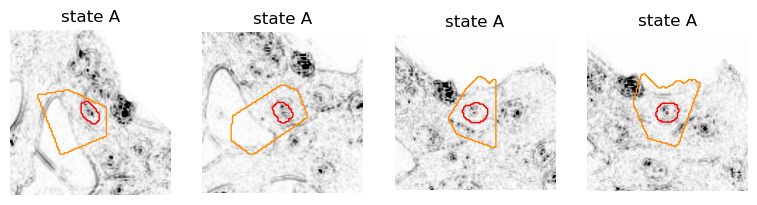

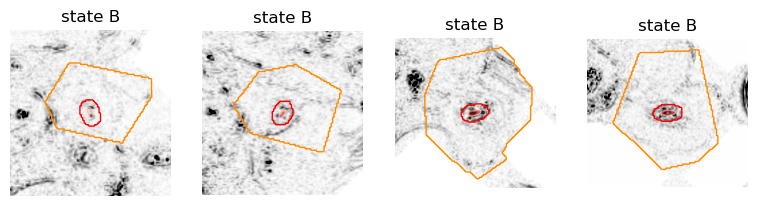

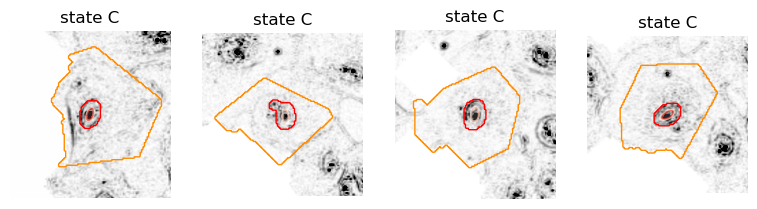

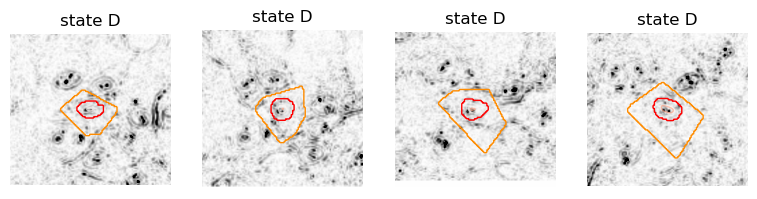

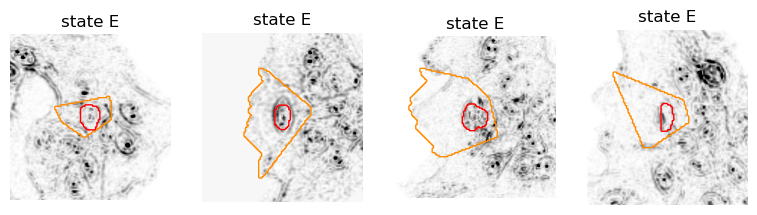

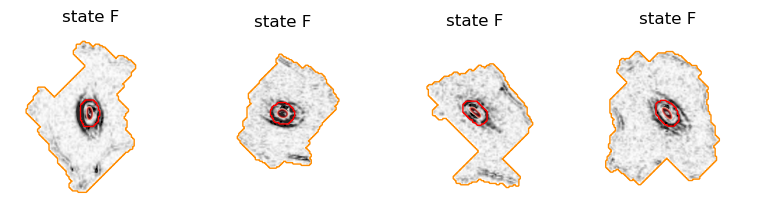

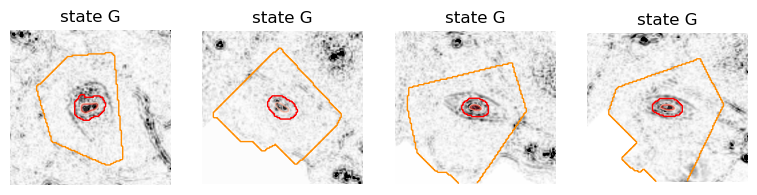

In [28]:
nrounds=1
nr=1
maxl=trajl
nuclow=-1.;nuchigh=9.;replow=0.;rephigh=5.;bflow=0.;bfhigh=5.
npics=4
for iround in range(nrounds):
    for istate in range(nstates):
        indcells_traj=inds_states[istate]
        indmodels=indtreatment_traj[indcells_traj]
        indcells_model=cellinds1_traj[indcells_traj]
        indr=np.random.choice(indcells_model.size,nr,replace=False)
        for ic in indr:
            plt.figure(figsize=(12,4))
            model_sctm=modelSet[indmodels[ic]]
            celltraj=model_sctm.get_cell_trajectory(indcells_model[ic])
            if celltraj.size>maxl:
                celltraj=celltraj[-maxl:]
            iplot=0
            for icell in np.linspace(0,celltraj.size-1,npics).astype(int):
                indcell=celltraj[icell]
                plt.subplot(1,npics+1,iplot+1)
                show_cell_2d(model_sctm,indcell,show_rep_channel=False,cyto_msk_channel=1,nuc_msk_channel=0,bf_img_channel=0,nuc_img_channel=1,rep_img_channel=2,nuclow=nuclow,nuchigh=nuchigh,replow=replow,rephigh=rephigh,bflow=bflow,bfhigh=bfhigh)
                iplot=iplot+1
                plt.title(f'state {state_labels[istate]}')

#### Building Likelihood Models for Each Treatment

In this section, we construct Markov State Models (MSMs) for each treatment condition to understand the state transition dynamics of cells under different treatments. We use two types of transition matrices: one for the raw states and one for the coarse-grained states.

In [29]:
MtSet=[None]*nf
MtSetCG=[None]*nf
for imf in range(nf):
    print('building likelihood model for '+tmSet[imf])
    indmodels=np.where(inds_tmSet_models==imf)[0]
    indmodels=np.intersect1d(indmodels,indgood_models)
    indstm=np.array([]).astype(int)
    for i in indmodels: #[:-1]:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==i)[0])
    MtSet[imf]=model.get_transition_matrix(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima);
    MtSetCG[imf]=model.get_transition_matrix_CG(x0set[indstm,:],x1set[indstm,:],clusters=clusters_minima,states=stateSet);

building likelihood model for EGF
building likelihood model for EGFTGFB
building likelihood model for OSM
building likelihood model for OSMEGF
building likelihood model for OSMEGFTGFB
building likelihood model for OSMTGFB
building likelihood model for PBS
building likelihood model for TGFB


### Temporal Evolution of State Probabilities

In this section, we analyze how the probabilities of different cell states evolve over time for each treatment condition. By dividing the time course into windows, we can observe dynamic changes in the distribution of cell states.

This analysis allows us to:
- **Monitor State Dynamics**: Observe how cell state distributions change over time for different treatments.
- **Identify Temporal Patterns**: Detect consistent temporal patterns in cell behavior induced by different treatments.

By examining the temporal evolution of state probabilities, we gain insights into the dynamic responses of cells under varying conditions.

In [30]:
nf=len(tmSet)
state_probs=np.zeros((nf,n_states))
nwindow=24
itimes=0
time_inds=np.arange(nwindow,modelSet[0].nt,nwindow).astype(int)
state_probs_times=np.zeros((nf,n_states,time_inds.size))
ntimes=time_inds.size
for itt in time_inds:
    fl=itt-nwindow
    fu=itt+nwindow
    indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
    for i in range(nf):
        indstm=inds_conditions[i]
        indstwm=np.intersect1d(indstm,indstw)
        x0=x[indstwm,:]
        indc0=stateSet[clusters_minima.assign(x0)]
        statesc,counts=np.unique(indc0,return_counts=True)
        state_probs[i,statesc]=counts/np.sum(counts)
    state_probs_times[:,:,itimes]=state_probs
    itimes=itimes+1

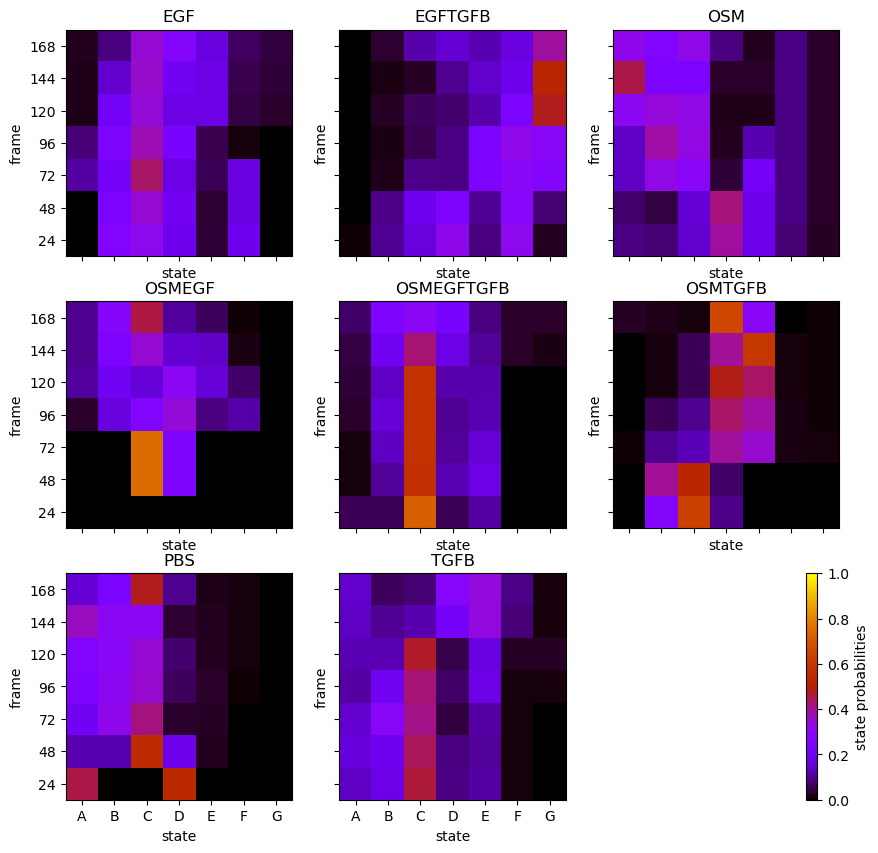

In [31]:
nplots=int(np.ceil(np.sqrt(nf+1)))
fig,ax=plt.subplots(nplots,nplots,sharex=True,sharey=True,figsize=(10,10))
ax=ax.flatten()
for i_tm in range(nf):
    im=ax[i_tm].imshow(state_probs_times[i_tm,:,:].T,origin='lower',cmap=plt.cm.gnuplot,clim=(0,1))
    ax[i_tm].set_yticks(np.arange(time_inds.size))
    ax[i_tm].set_xticks(np.arange(nstates))
    ax[i_tm].set_xticklabels(np.array(state_labels))
    ax[i_tm].set_yticklabels(time_inds)
    ax[i_tm].set_xlabel('state');ax[i_tm].set_ylabel('frame')
    ax[i_tm].set_title(tmSet[i_tm])

ax[nf].axis('off')
cbar=fig.colorbar(im,ax=ax[nf])
cbar.set_label('state probabilities')

#### Extract state probabilities at t=24hrs
We will decompose RNAseq data obtained at t=24hrs after ligand addition, so we utilize single-cell trajectory snippets whose last frame lies in a 12-hour time window centered at t=24hrs to define state populations.

In [32]:
fl=72
fu=120
cell_states=clusters_minima
indstw=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
for i in range(nf):
    indstm=inds_conditions[i]
    indstwm=np.intersect1d(indstm,indstw)
    x0=x[indstwm,:]
    indc0=stateSet[clusters_minima.assign(x0)]
    statesc,counts=np.unique(indc0,return_counts=True)
    state_probs[i,statesc]=counts/np.sum(counts)

Text(0.5, 1.0, 'state probabilities at t=24hr time window')

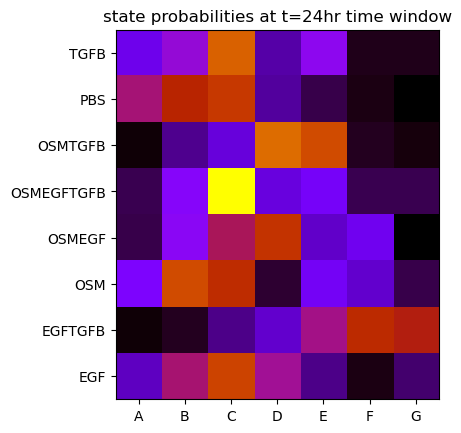

In [33]:
plt.imshow(state_probs,origin='lower',cmap=plt.cm.gnuplot)
ax=plt.gca()
ax.set_yticks(np.arange(nf))
ax.set_xticks(np.arange(nstates))
ax.set_xticklabels(np.array(state_labels))
ax.set_yticklabels(tmSet)
plt.title('state probabilities at t=24hr time window')

### Visualizing State Transitions with Flux Arrows
We visualize the transitions between different cell states in the morphodynamical landscape via the flux carried between states where flux is defined by the state probability at t=24hrs multiplied by the transition probability between states (derived from all timepoints in each condition separately). This analysis helps us understand how cells dynamically change their states under various conditions. The flux arrows illustrate the direction of state transitions, providing insights into the behavior and stability of cell states in different ligand treatments.

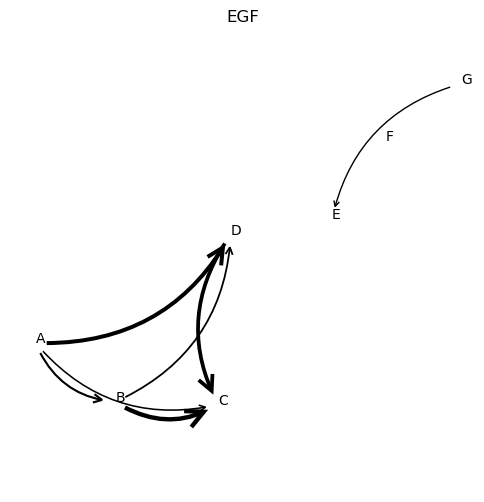

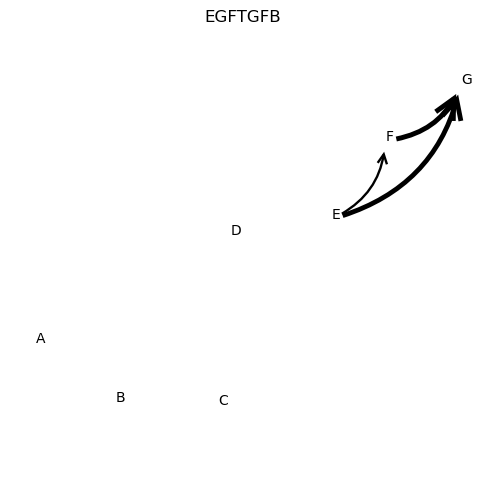

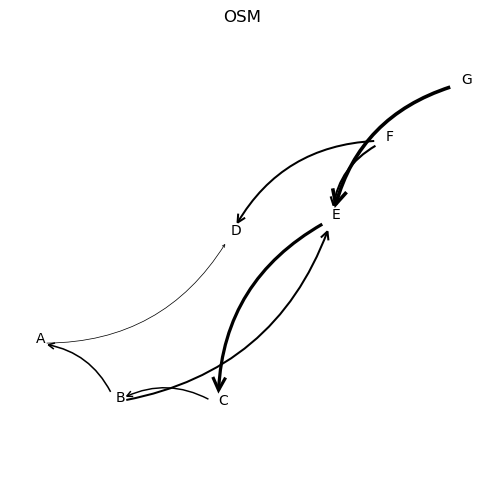

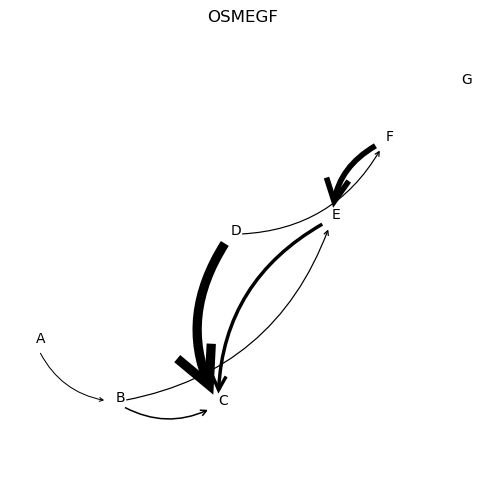

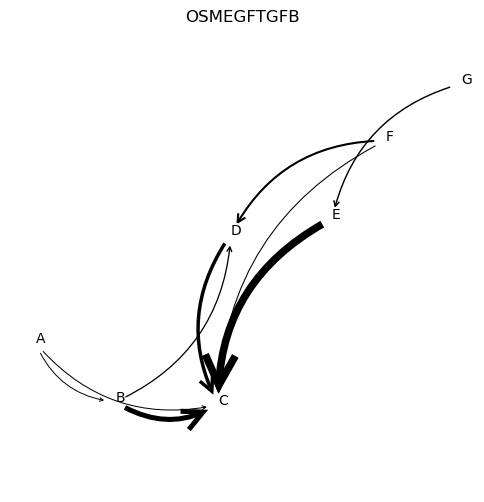

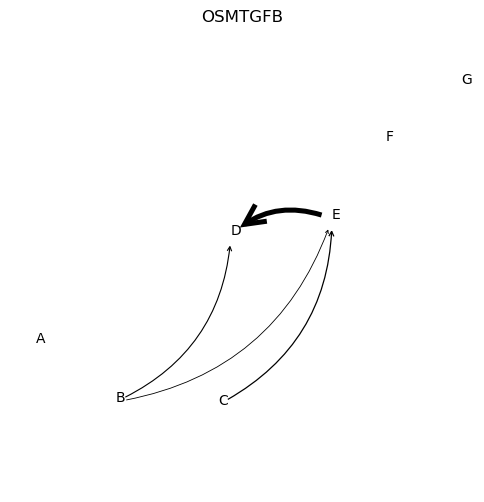

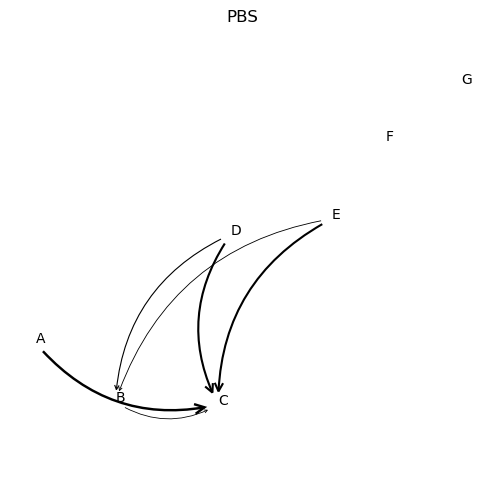

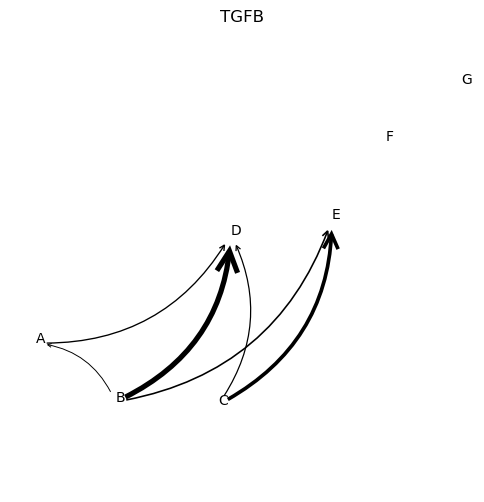

In [34]:
pcut=.02
fcut=.005
rad=.3
mscale=1000
arrowstyle='->'
lws=100.
sh=8
state_centers=state_centers_minima
indstw_all=np.where(np.logical_and(indframes_traj<fu,indframes_traj>fl))[0]
xmin=np.min(x_clusters[:,0])
xmax=np.max(x_clusters[:,0])
ymin=np.min(x_clusters[:,1])
ymax=np.max(x_clusters[:,1])
for i in range(nf):
    plt.figure(figsize=(6,6))
    indstm=np.array([]).astype(int)
    for imodel in indmodels:
        indstm=np.append(indstm,np.where(inds_trajsteps_models==imodel)[0].astype(int))
    x0=x0set[indstm,:]
    x1=x1set[indstm,:]
    Mt=MtSetCG[i]
    ax=plt.gca()
    for j in range(n_states):
        for k in range(n_states):
            fluxjk=state_probs[i,j]*Mt[j,k]
            fluxkj=state_probs[i,j]*Mt[k,j]
            flux=fluxjk-fluxkj
            if j<k and flux>fcut and state_probs[i,j]>pcut: #Mt[j,k]>pcut:
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*flux,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*flux,joinstyle='miter',capstyle='butt') #note j and k flipped because drawing arrow at tail
                ax.add_patch(arrow)
            if j>k and flux>fcut and state_probs[i,j]>pcut: #Mt[j,k]>pcut:
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*flux,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*flux,joinstyle='miter',capstyle='butt')
                ax.add_patch(arrow)
        plt.text(state_centers[j,0],state_centers[j,1],state_labels[j],color='black',ma='center')
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax+.5)
    plt.axis('off')
    plt.title(tmSet[i])
    plt.pause(.1)


### State Transition Pathways and Committors
In this analysis, we visualize the state transition pathways and committors to understand how cells transition between different states. This is particularly useful for identifying the most probable paths cells take between defined states under different conditions.

#### Key Concepts:
State Transition Pathways: These pathways show the most probable sequences of state transitions from a source state (State A) to a target state (State B).
Committors: The committor function represents the probability of reaching the target state (State B) before the source state (State A) from any given state.

#### Implementation Steps:

1. **Define Source and Target States:**
State A is defined as the source state(s) and State B as the target state(s).
Cells in these states are identified and marked in the plot.

2. **Calculate Transition Probabilities:**
The transition probability matrix (Tmatrix) is used to compute the likelihood of transitions between states.
The committor function is calculated for each state to determine the probability of reaching the target state before the source state.

3. **Visualize Transition Pathways:**
The most probable pathways are identified using Transition Path Theory (TPT) and visualized with arrows indicating the direction and magnitude of the flux between states.
Arrows are scaled to represent the flux magnitude, providing a visual representation of the flow of cells between states.

4. **Show Committor Values:**
Commitment probabilities, the probability to arrive at the target state before returning to the source state, are plotted using a contour plot, where each state's committor value is represented by a color gradient.

This visualization helps in understanding the dynamics of cell state transitions, revealing the consistency of the state transition sequences between source and target states, and the influence of different treatments on the cellular pathways and their state change commitment.

/tmp/ipykernel_1138/4194892723.py:41: RuntimeWarning: invalid value encountered in divide
  vdist1=np.divide(vdist1,norm1)


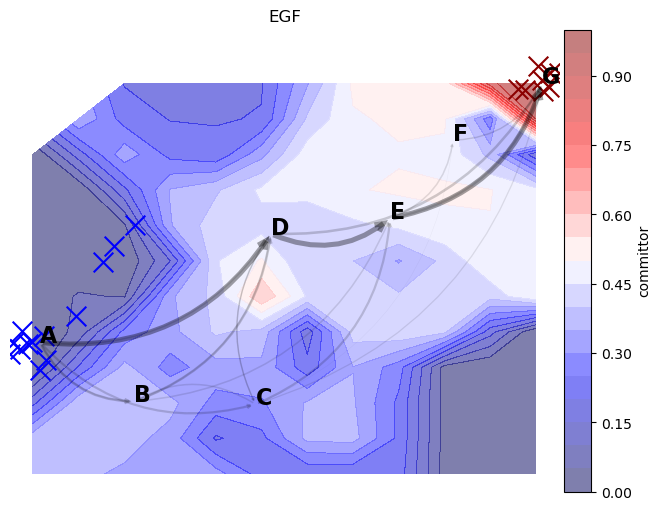

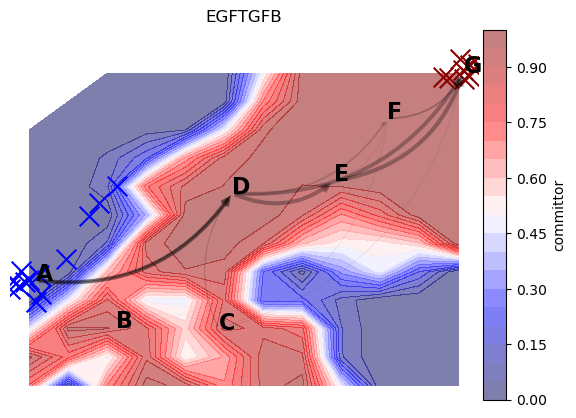

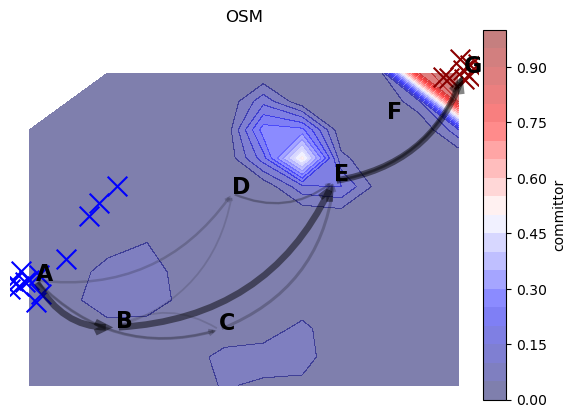

Input matrix is not weakly connected. Therefore it has no unique stationary distribution. Separate disconnected components and handle them separately


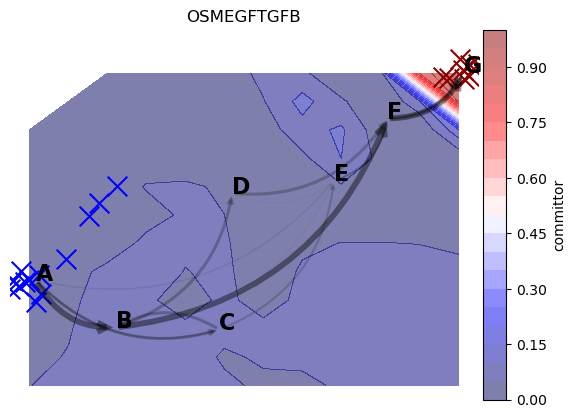

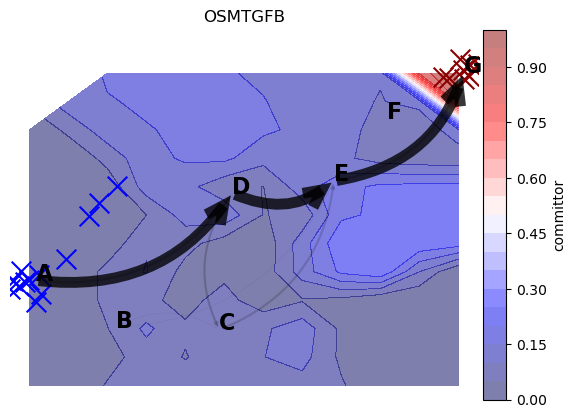

Input matrix is not weakly connected. Therefore it has no unique stationary distribution. Separate disconnected components and handle them separately


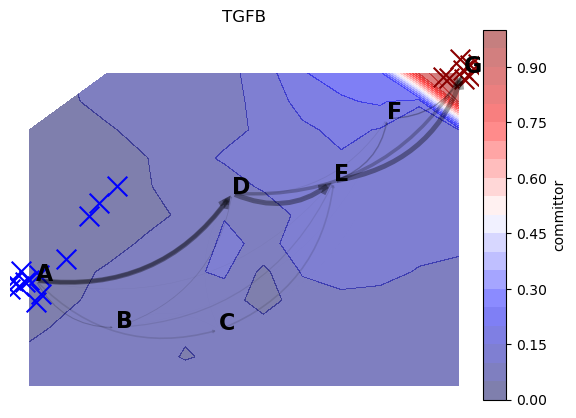

In [36]:
pcut=.05
fcut=0.
rad=.3
mscale=40.
arrowstyle='->'
lws=10.
sh=2
state_centers=state_centers_minima
commsize=100
xmin=np.min(x_clusters[:,0])
xmax=np.max(x_clusters[:,0])
ymin=np.min(x_clusters[:,1])
ymax=np.max(x_clusters[:,1])
plt.figure(figsize=(7.5,6))
stateA=[0]; stateB=[6]
indSource=np.array([]).astype(int)
for isource in stateA:
    inds=np.where(stateSet==isource)[0]
    indSource=np.append(indSource,inds)

indTargets=np.array([]).astype(int)
for itargets in stateB:
    inds=np.where(stateSet==itargets)[0]
    indTargets=np.append(indTargets,inds)

for i in range(nf):
    #plt.subplot(4,4,i+2)
    plt.clf()
    Tmatrix=MtSet[i]
    indNotTargets=np.setdiff1d(range(Tmatrix.shape[0]),indTargets)
    indNotSource=np.setdiff1d(range(Tmatrix.shape[0]),indSource)
    prob=prob1
    levels=np.linspace(np.min(prob[prob>0]),np.max(prob),20)
    #plt.contourf(xx,yy,prob.T,levels=levels,cmap=plt.cm.gray_r,alpha=0.8)
    q=model.get_committor(Tmatrix,indTargets,indSource,conv=1.e-3)
    #plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=q,cmap=plt.cm.gist_heat,marker='o',vmin=0.,vmax=1.)
    vdist1,xedges1,yedges1=np.histogram2d(x_clusters[:,0],x_clusters[:,1],bins=nbins,weights=q.flatten())
    vdist1=scipy.ndimage.gaussian_filter(vdist1,sigma=sml)
    norm1,xedges1,yedges1=np.histogram2d(x_clusters[:,0],x_clusters[:,1],bins=[xedges1,yedges1])
    norm1=scipy.ndimage.gaussian_filter(norm1,sigma=sml)
    vdist1=np.divide(vdist1,norm1)
    indnan=np.where(np.isnan(vdist1))
    indgood=np.where(np.logical_and(np.logical_not(np.isnan(vdist1)),np.logical_not(np.isinf(vdist1))))
    xedges1c=.5*(xedges1[1:]+xedges1[0:-1])
    yedges1c=.5*(yedges1[1:]+yedges1[0:-1])
    xx1,yy1=np.meshgrid(xedges1c,yedges1c)
    levels=np.linspace(0,1,21) #np.min(vdist1[indgood]),np.max(vdist1[indgood]),20)
    cs=plt.contourf(xx,yy,vdist1.T,cmap=plt.cm.seismic,levels=levels,alpha=0.5)
    cbar=utilities.colorbar(cs)
    cbar.set_label('committor')
    plt.scatter(x_clusters[indTargets,0],x_clusters[indTargets,1],s=200,c='darkred',marker='x')
    plt.scatter(x_clusters[indSource,0],x_clusters[indSource,1],s=200,c='blue',marker='x')
    #pts=np.array([xx1.flatten(),yy1.flatten()]).T
    #indpts=clusters_2d.assign(pts)
    #states=stateSet[indpts]
    #plt.contour(xx,yy,states.reshape(nbins,nbins),levels=np.arange(nstates),colors='black')
    try:
        tpt=msmtools.flux.tpt(MtSetCG[i],stateA,stateB)
        pathways=tpt.pathways()
        paths=pathways[0]
        capacities=pathways[1]
        ax=plt.gca()
        for ipath in range(-1,-len(paths)-1,-1):
            statepath=paths[ipath]
            colorpath=capacities[ipath]/np.sum(capacities)
            for ipath in range(statepath.size-1):
                j=statepath[ipath]
                k=statepath[ipath+1]
                arrow = matplotlib.patches.FancyArrowPatch((state_centers[j,0], state_centers[j,1]), (state_centers[k,0], state_centers[k,1]),shrinkA=sh,shrinkB=sh,mutation_scale=mscale*colorpath,color='black',arrowstyle=arrowstyle,connectionstyle='arc3,rad='+str(rad),lw=lws*colorpath,joinstyle='miter',capstyle='butt',alpha=colorpath) #note j and k flipped because drawing arrow at tail
                ax.add_patch(arrow)
        for j in range(n_states):
            scolor=tpt.committor[j]+.01
            #plt.scatter(state_centers[j,0],state_centers[j,1],s=commsize,c=plt.cm.gist_heat(scolor),alpha=0.3)
            plt.text(state_centers[j,0],state_centers[j,1],state_labels[j],color='black',weight='bold',fontsize=16,ma='center')
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax+.5)
        plt.axis('off')
        plt.title(tmSet[i])
        plt.pause(5)
    except Exception as e:
        print(e)
        pass


## Linking Morphodynamical States to Gene Expression
In this section, we describe the process of mapping morphodynamical observations to gene expression levels. The goal is to understand how changes in morphodynamical cell states correspond to changes in RNA transcript levels, providing insights into the molecular mechanisms underlying observed cellular behaviors.

- **Overview**
To establish this link, we leverage both morphodynamical data (observations of cell behavior over time) and molecular measurements (RNA transcript levels) for a consistent set of experimental treatments. The core hypothesis is that specific morphodynamical states correspond to distinct gene expression profiles, regardless of the treatment applied, and that the ligand treatments primarily act by altering transition rates between these morphodynamical states.

- **Linear Algebra Framework:**

Decompose each measured average transcript level as a linear sum over morphodynamical state populations and their corresponding gene expression profiles. This allows for the quantification of the relationship between cell state frequencies and gene expression levels.

### Differential Expression Data Loading and Filtering
In this section, we load RNA sequencing data and differential expression analysis results to identify significantly expressed genes. We then create a data matrix of log2 fold changes and adjusted p-values for further analysis.

**Steps**
1. Load RNA Sequencing Data:

Read the RNA sequencing data from a CSV file containing log2(TPM) values for protein-coding genes.

2.Filter Genes Based on Expression Levels:
Apply a filter to select genes with log2(TPM) > 0.5 in at least two conditions.
Ensure that only genes with valid names are considered.
Extract gene names and Ensembl gene IDs for the filtered genes.

3. Read Differential Expression Analysis Results:
Load DESeq2 differential expression analysis results for each ligand treatment compared to the control.

4. Construct Differential Expression Data Matrix:
Create matrices for log2 fold changes (x_lfc) and adjusted p-values (x_padj) for the filtered genes.
Populate these matrices with the corresponding values from the DESeq2 results.
Filter out genes with non-finite log2 fold changes.

**Output Data Structures:**
- `x_lfc`: Matrix of log2 fold changes for each ligand treatment and each gene.
- `x_padj`: Matrix of adjusted p-values for each ligand treatment and each gene.
- `x_fc`: Matrix of fold changes (2^log2 fold changes) for each ligand treatment and each gene.
- `gene_names`: Names of the filtered genes.
- `ensembl_gene_ids`: Ensembl gene IDs of the filtered genes.

In [127]:
seqFile='MDD_ligandCombination_RNAseq_log2TPM_proteinCoding.csv'
seqData=pandas.read_csv(f'{datapath}/{seqFile}')

#create a filter for log2(TPM)>0.5 in 2 conditions
ind_minexpr=np.where(np.sum(seqData.iloc[:,3:]>0.5,axis=1)>=2)[0]
geneNames = seqData['hgnc_symbol']
ind_nan = np.where(np.logical_not(pandas.isna(seqData['hgnc_symbol'])))[0] #also genes with names
ensembl_gene_id = seqData['ensembl_gene_id']
ind_expressed = np.intersect1d(ind_minexpr,ind_nan)
gene_names=geneNames[ind_expressed]
gene_names=gene_names.reset_index(drop=True)
ensembl_gene_ids=ensembl_gene_id[ind_expressed]
ensembl_gene_ids=ensembl_gene_ids.reset_index(drop=True)

#read in DEseq2 differential expression analysis
deseq=[None]*nf
for i_tm in range(nf):
    seqfile=f'deseq2_DE_lfcshrink_ligands_{tmSet[i_tm]}_vs_CTRL.csv'
    deseq[i_tm]=pandas.read_csv(f'{datapath}/{seqfile}')

#now put together differential expression data matrix protein coding nG0
nG=ind_expressed.size
inds_dataset=np.zeros(nf).astype(int)
nsamples=inds_dataset.size
x_lfc=np.ones((nsamples,nG))*np.nan
x_padj=np.ones((nsamples,nG))*np.nan
seq_genes=deseq[0]['Unnamed: 0']
for i in range(nG):
    if i%1000==0:
        print(f'matching gene {str(i)} of {str(nG)}')
    gene_name=ensembl_gene_ids.iloc[i]
    indgene=np.where(seq_genes==gene_name)[0]
    if indgene.size>0:
        for i_tm in range(nf):
            lfc=deseq[i_tm].iloc[ind_expressed[i]]['log2FoldChange']
            padj=deseq[i_tm].iloc[ind_expressed[i]]['padj']
            x_lfc[i_tm,i]=lfc
            x_padj[i_tm,i]=padj

inds_finite=np.where(np.isfinite(np.sum(x_lfc,axis=0)))[0]
print(f'dropping {nG-inds_finite.size} genes of {nG} total...')
x_lfc=x_lfc[:,inds_finite]
x_padj=x_padj[:,inds_finite]
x_fc=2**x_lfc
gene_names=gene_names.iloc[inds_finite]
gene_names=gene_names.reset_index(drop=True)
ensembl_gene_ids=ensembl_gene_ids.iloc[inds_finite]
ensembl_gene_ids=ensembl_gene_ids.reset_index(drop=True)

matching gene 0 of 14832
matching gene 1000 of 14832
matching gene 2000 of 14832
matching gene 3000 of 14832
matching gene 4000 of 14832
matching gene 5000 of 14832
matching gene 6000 of 14832
matching gene 7000 of 14832
matching gene 8000 of 14832
matching gene 9000 of 14832
matching gene 10000 of 14832
matching gene 11000 of 14832
matching gene 12000 of 14832
matching gene 13000 of 14832
matching gene 14000 of 14832
dropping 0 genes of 14832 total...


In [129]:
#trim to most variable genes
min_fc=np.min(x_fc[x_fc>0.])
control_fc=np.power(np.product(x_fc+min_fc,axis=0),1./nf)
x_lfc=np.log2(x_fc+min_fc)
x_lfc=x_lfc-np.log2(control_fc) #0 centering to get rid of t=0 signal
Nv=500
gvars=np.std(np.log2(x_fc+min_fc),axis=0)
indvar=np.argsort(gvars)[-Nv:]
#ind_genes=ind_expr_control[indvar]
ind_genes=indvar.copy()
gene_names=gene_names[ind_genes]
x_fc=x_fc[:,indvar]
x_lfc=np.log2(x_fc+min_fc)
nG=Nv
date='11feb25'
figid=f'loco_nG{Nv}'
os.system(f'mkdir {date}')

mkdir: cannot create directory ‘11feb25’: File exists


256

#### Check Grouping of RNAseq Data by Treatment
In this section, we perform Principal Component Analysis (PCA) on the RNA sequencing data to visualize the overall grouping of treatments based on gene expression profiles.

([Text(16.018859007966157, -29.17316297834996, 'EGF'),
  Text(-1.2607612792410805, -32.88658658945255, 'EGFTGFB'),
  Text(-11.686624255487082, 37.89569626369604, 'OSM'),
  Text(-36.48368837133324, -9.2754052544012, 'OSMEGF'),
  Text(-36.488493102108244, -5.204401895774517, 'OSMEGFTGFB'),
  Text(-15.640068212276262, 32.81404423668506, 'OSMTGFB'),
  Text(70.18765963803585, 7.524114956666523, 'PBS'),
  Text(59.54331663842544, 5.445460997861247, 'TGFB')],
  <matplotlib.patches.FancyArrowPatch at 0x7fd3bbcc9730>])

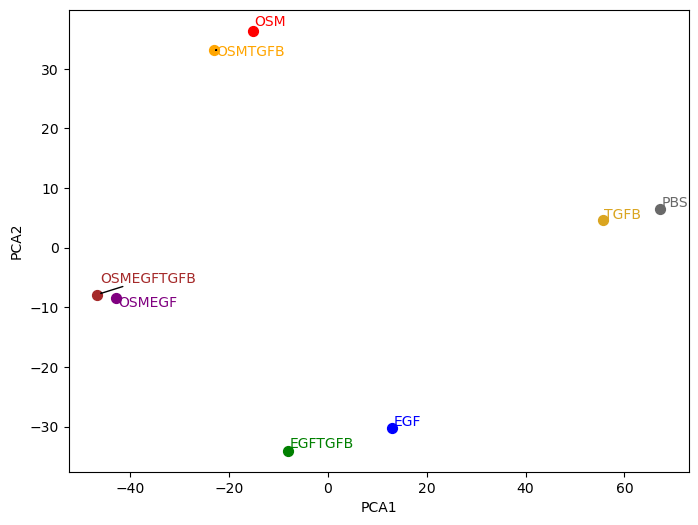

In [130]:
Xpca,pca=features.get_pca_fromdata(x_lfc,var_cutoff=.95)
plt.figure(figsize=(8,6))
from adjustText import adjust_text
texts=[None]*Xpca.shape[0]
for i in range(nf):
    plt.scatter(Xpca[i,0],Xpca[i,1],s=50,c=colorSet[i])
    text=plt.text(Xpca[i,0],Xpca[i,1],tmSet[i],color=colorSet[i])
    texts[i]=text
plt.xlabel('PCA1');plt.ylabel('PCA2')
adjust_text(texts,arrowprops=dict(arrowstyle='->', color='black'))

### Decomposition of RNAseq Data Using Leave-One-Out Cross-Validation
In this section, we will decompose RNA sequencing data for each experimental condition using a leave-one-out cross-validation approach. This method involves training the decomposition model on all but one condition and then testing it on the excluded condition.

The decomposition is performed using the `get_state_decomposition` function from the [celltraj.translate](https://jcopperm.github.io/celltraj/api.html#celltraj-translate) module, which decomposes the measured average fold change into the states identified in the previous morphodynamical analysis.

#### Steps Explained:
Loop through each condition: For each condition i_tm in the number of conditions nf:
- Define test and training sets: Exclude the current condition (i_tm) to create the training set (inds_tm_training) and use it for testing (inds_tm_test).
- Perform decomposition: Call the `get_state_decomposition` function with the training set, state probabilities, and other necessary parameters. The result is stored in `x_fc_states`.


RNAseq decomposition, training: ['EGFTGFB' 'OSM' 'OSMEGF' 'OSMEGFTGFB' 'OSMTGFB' 'PBS' 'TGFB'], test: ['EGF']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


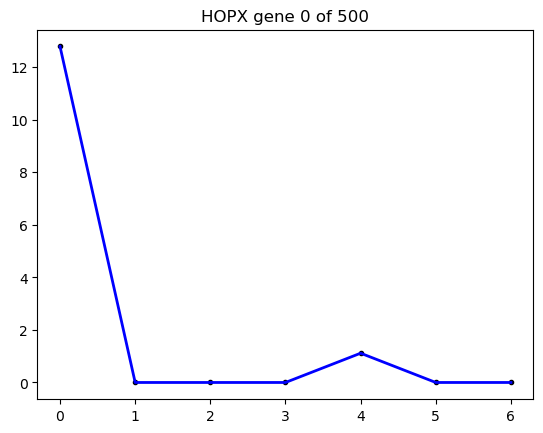

RNAseq decomposition, training: ['EGF' 'OSM' 'OSMEGF' 'OSMEGFTGFB' 'OSMTGFB' 'PBS' 'TGFB'], test: ['EGFTGFB']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSMEGF' 'OSMEGFTGFB' 'OSMTGFB' 'PBS' 'TGFB'], test: ['OSM']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


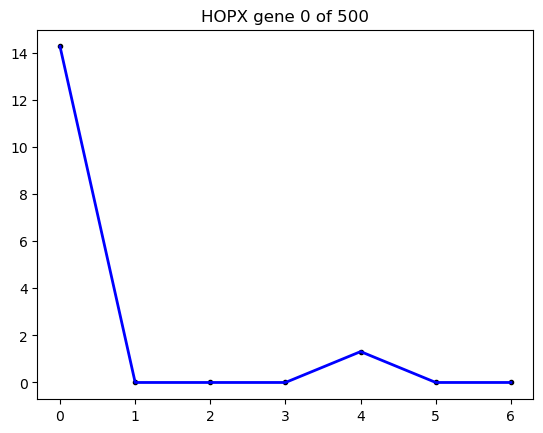

RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSM' 'OSMEGFTGFB' 'OSMTGFB' 'PBS' 'TGFB'], test: ['OSMEGF']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSM' 'OSMEGF' 'OSMTGFB' 'PBS' 'TGFB'], test: ['OSMEGFTGFB']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


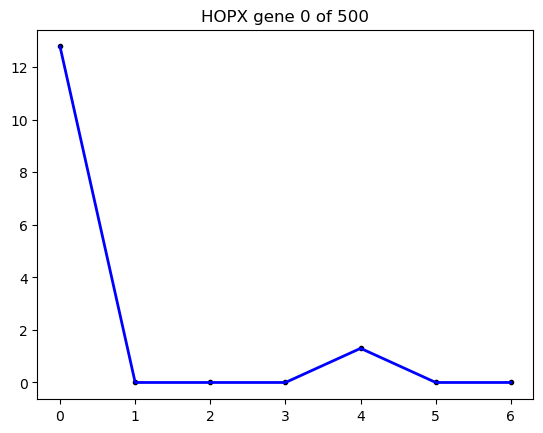

RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSM' 'OSMEGF' 'OSMEGFTGFB' 'PBS' 'TGFB'], test: ['OSMTGFB']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


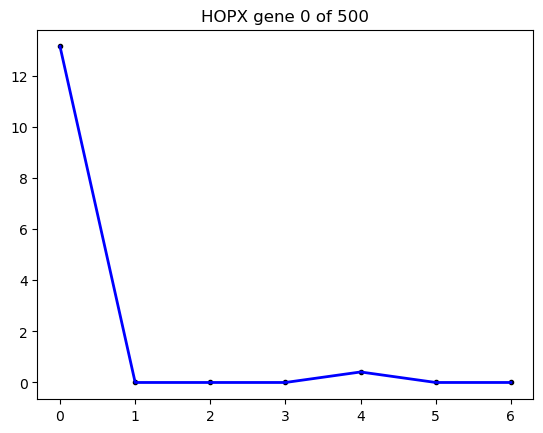

RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSM' 'OSMEGF' 'OSMEGFTGFB' 'OSMTGFB' 'TGFB'], test: ['PBS']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


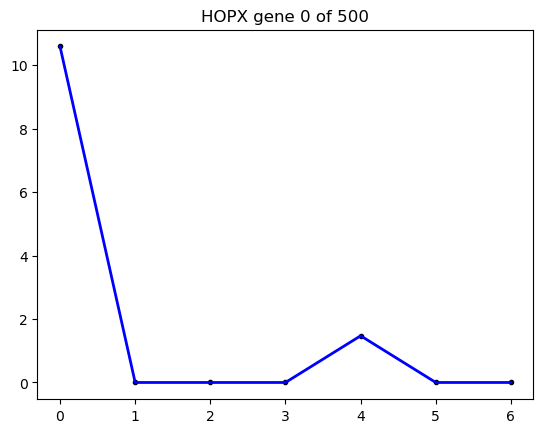

RNAseq decomposition, training: ['EGF' 'EGFTGFB' 'OSM' 'OSMEGF' 'OSMEGFTGFB' 'OSMTGFB' 'PBS'], test: ['TGFB']
1 possible permutations of 8 training measurements decomposed into 7 states
using 1 of 1 possible training set permutations randomly per feature
decomposing gene 0 of 500


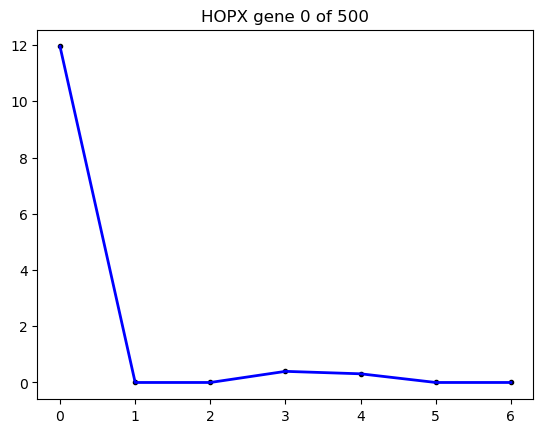

In [131]:
#perform decomposition of RNAseq over each condition, leaving one condition out cross-validation
x_fc_states_loco=[None]*nf
for i_tm in range(nf):
    inds_tm_test=np.array([i_tm])
    inds_tm_training=np.setdiff1d(np.arange(nf).astype(int),inds_tm_test)
    print(f'RNAseq decomposition, training: {np.array(tmSet)[inds_tm_training]}, test: {np.array(tmSet)[inds_tm_test]}')
    x_fc_states=translate.get_state_decomposition(x_fc,state_probs,inds_tm_training=inds_tm_training,visual=True,nchunk=1000,gene_names=gene_names,verbose=True)
    x_fc_states_loco[i_tm]=x_fc_states.copy()

#### Predicting Gene Expression for Leave-One-Out Cross-Validation
In this section, we will predict gene expression for each condition using the leave-one-out cross-validation results obtained from the previous step. We will then calculate the correlation between the predicted and actual gene expression levels to evaluate the performance of our model.

In [132]:
#get predicted gene expression for each leave one out cross validation
x_fc_predicted=np.zeros((nf,nG))
for i_tm in range(nf):
    x_fc_states=x_fc_states_loco[i_tm]
    x_fc_predicted=translate.get_predictedFC(state_probs,x_fc_states)
    x_fc_predicted[i_tm,:]=x_fc_predicted[i_tm,:]+np.min(x_fc) #add in a null of min measured fc

x_lfc_predicted=np.log2(x_fc_predicted)
corrSet_pred=np.zeros(nf)
for i_tm in range(nf):
    corrSet_pred[i_tm]=np.corrcoef(x_lfc[i_tm,:],x_lfc_predicted[i_tm,:])[0,1]
    print(f'{tmSet[i_tm]} corr: {corrSet_pred[i_tm]:.2f}')

EGF corr: 0.69
EGFTGFB corr: 0.86
OSM corr: 0.87
OSMEGF corr: 0.92
OSMEGFTGFB corr: 0.95
OSMTGFB corr: 0.96
PBS corr: 0.04
TGFB corr: 0.34


In [133]:
#get cross-correlations between each ligand treatment
min_fc=np.min(x_fc[x_fc>0])
x_lfc=np.log2(x_fc+min_fc)

#x_lfc=x_fc.copy()
corrSet_condmatrix=np.zeros((nf,nf))
for i_tm in range(nf):
    for j_tm in range(nf):
        corrSet_condmatrix[i_tm,j_tm]=np.corrcoef(x_lfc[i_tm,:],x_lfc[j_tm,:])[0,1]
        #corrSet_condmatrix[i_tm,j_tm]=np.corrcoef(x_counts_log[i_tm,indvar],x_counts_log[j_tm,indvar])[0,1]
        print(f'{tmSet[i_tm]}--{tmSet[j_tm]} corr: {corrSet_condmatrix[i_tm,j_tm]:.2f}')

EGF--EGF corr: 1.00
EGF--EGFTGFB corr: 0.83
EGF--OSM corr: 0.49
EGF--OSMEGF corr: 0.74
EGF--OSMEGFTGFB corr: 0.71
EGF--OSMTGFB corr: 0.51
EGF--PBS corr: -0.34
EGF--TGFB corr: 0.10
EGFTGFB--EGF corr: 0.83
EGFTGFB--EGFTGFB corr: 1.00
EGFTGFB--OSM corr: 0.54
EGFTGFB--OSMEGF corr: 0.73
EGFTGFB--OSMEGFTGFB corr: 0.86
EGFTGFB--OSMTGFB corr: 0.70
EGFTGFB--PBS corr: -0.30
EGFTGFB--TGFB corr: 0.35
OSM--EGF corr: 0.49
OSM--EGFTGFB corr: 0.54
OSM--OSM corr: 1.00
OSM--OSMEGF corr: 0.84
OSM--OSMEGFTGFB corr: 0.79
OSM--OSMTGFB corr: 0.89
OSM--PBS corr: -0.22
OSM--TGFB corr: 0.10
OSMEGF--EGF corr: 0.74
OSMEGF--EGFTGFB corr: 0.73
OSMEGF--OSM corr: 0.84
OSMEGF--OSMEGF corr: 1.00
OSMEGF--OSMEGFTGFB corr: 0.88
OSMEGF--OSMTGFB corr: 0.80
OSMEGF--PBS corr: -0.38
OSMEGF--TGFB corr: 0.01
OSMEGFTGFB--EGF corr: 0.71
OSMEGFTGFB--EGFTGFB corr: 0.86
OSMEGFTGFB--OSM corr: 0.79
OSMEGFTGFB--OSMEGF corr: 0.88
OSMEGFTGFB--OSMEGFTGFB corr: 1.00
OSMEGFTGFB--OSMTGFB corr: 0.90
OSMEGFTGFB--PBS corr: -0.30
OSMEGFTGFB--TGFB

#### Visualizing Gene Expression: Measured vs. Predicted
In this section, we will visualize the measured and predicted gene expression levels for the top varying genes using heatmaps. This allows us to compare the actual and predicted expression patterns across different experimental conditions.

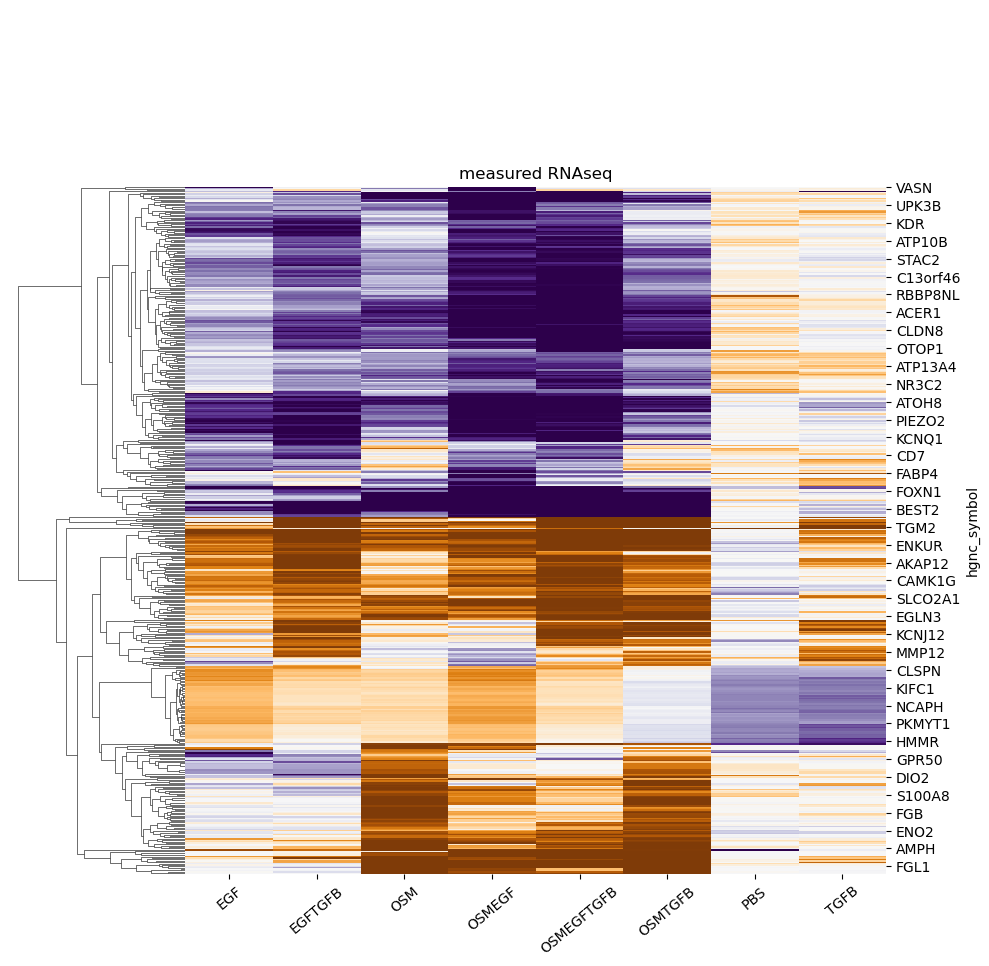

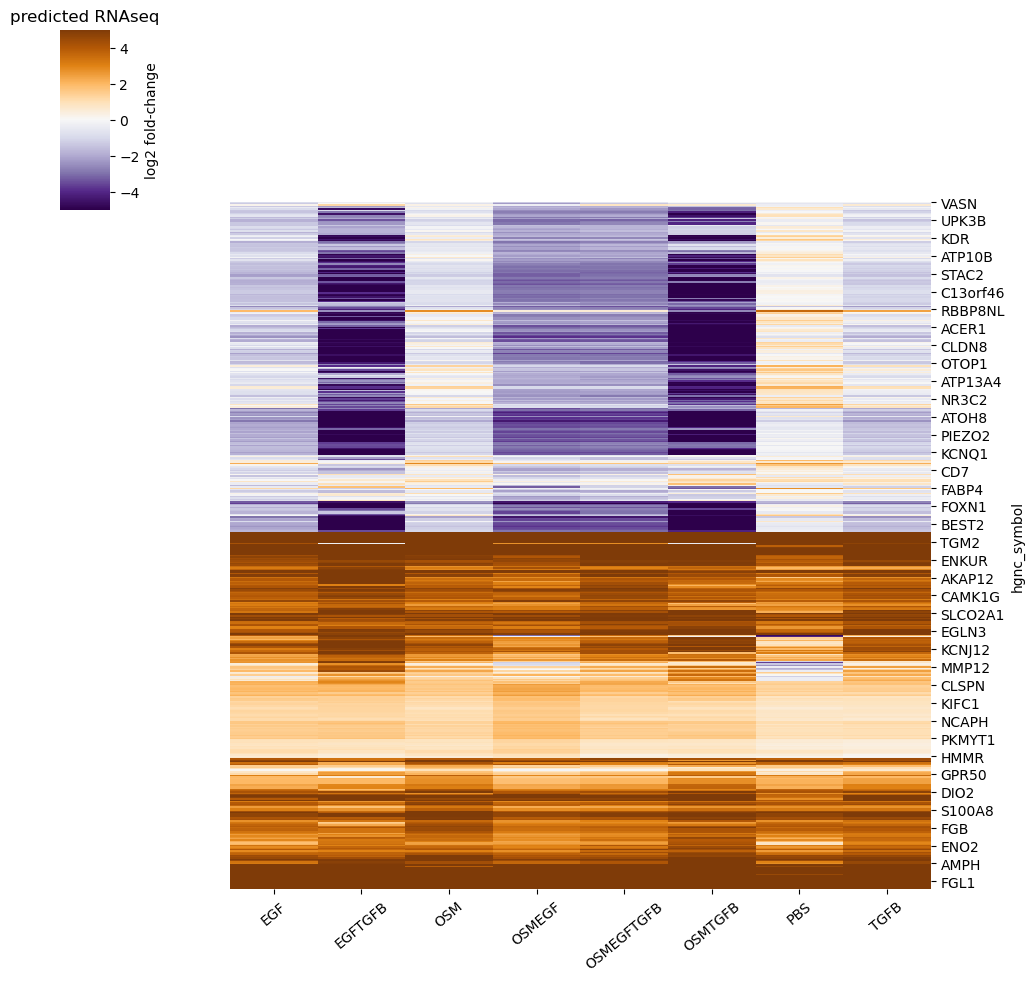

In [134]:
#Nv=100
nticks=30

gvars=np.std(x_lfc,axis=0)
indvar=np.argsort(gvars)[-Nv:]
tick_genes=gene_names.iloc[indvar][-nticks:]
df_cond_measured=pandas.DataFrame(data=x_lfc[:,indvar].T,index=gene_names.iloc[indvar],columns=tmSet)
hmap = sns.clustermap(df_cond_measured,cmap="PuOr_r",cbar_kws={'label': 'log2 fold-change'},cbar_pos=None,col_cluster=False,vmin=-5,vmax=5)
reord_inds=hmap.dendrogram_row.reordered_ind.copy()
plt.setp(hmap.ax_heatmap.get_xticklabels(), rotation=40)
plt.title('measured RNAseq')

df_cond_predicted=pandas.DataFrame(data=x_lfc_predicted[:,indvar[reord_inds]].T,index=gene_names.iloc[indvar[reord_inds]],columns=tmSet)
hmap = sns.clustermap(df_cond_predicted,cmap="PuOr_r",cbar_kws={'label': 'log2 fold-change'},col_cluster=False,row_cluster=False,vmin=-5,vmax=5)
plt.setp(hmap.ax_heatmap.get_xticklabels(), rotation=40)
plt.title('predicted RNAseq')

plt.savefig(f'{date}/heatmap_{figid}.png')
plt.savefig(f'{date}/heatmap_{figid}.pdf')

#### Validating Gene Expression Predictions with Null Models
To validate our gene expression predictions, we compare them to a null model generated using random state populations. This allows us to assess the significance of our predictions by determining how well they correlate with actual measurements relative to random expectations.

In [110]:
#get null correlation set using random state populations
validation_results=[None]*nf
for i_tm in range(nf):
    print(f'gathering null predictions from {tmSet[i_tm]}')
    cpred, corrSet_rand, corrSet_predrand = translate.get_null_correlations(x_fc,x_fc_states,x_fc_predicted,nrandom=500)
    validation_results[i_tm]=corrSet_rand[:,i_tm]

gathering null predictions from EGF
gathering null predictions from EGFTGFB
gathering null predictions from OSM
gathering null predictions from OSMEGF
gathering null predictions from OSMEGFTGFB
gathering null predictions from OSMTGFB
gathering null predictions from PBS
gathering null predictions from TGFB


#### Correlation between predicted and measured gene expression
The correlation between the predicted and actual gene expression levels are plotted as red dots. Null model predictions are shown as gray violin plots.

In [135]:
fig=plt.figure(figsize=(10,6))
ax=plt.gca()
for i_tm in range(nf):
    corrSet_rand=validation_results[i_tm]
    vplot=ax.violinplot(corrSet_rand,positions=[i_tm+1],showmeans=True,showextrema=False,quantiles=[.025,.975])
    for partname in ('cmeans','cquantiles'):
        vp = vplot[partname]
        vp.set_edgecolor('black')
    plt.scatter(i_tm+1,corrSet_pred[i_tm],s=100,c='red',marker='d')
    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        pc.set_edgecolor('black')
        #pc.set_alpha(1)

ax.set_xticks(np.arange(1,nf+1))
ax.set_xticklabels(tmSet)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right",rotation_mode="anchor")
plt.ylabel('correlation'); plt.ylim(-1.,1.)

(-1.0, 1.0)

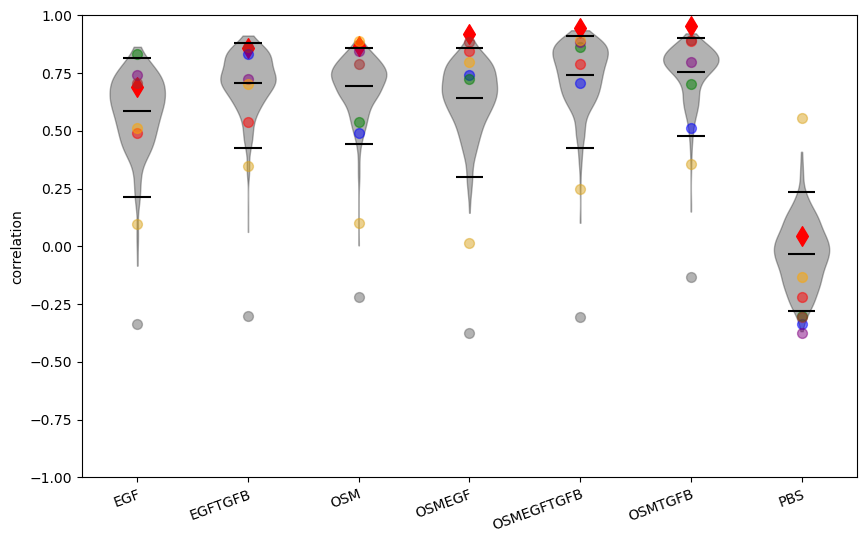

In [136]:
fig=plt.figure(figsize=(10,6))
ax=plt.gca()
for i_tm in range(nf):
    corrSet_rand=validation_results[i_tm]
    vplot=ax.violinplot(corrSet_rand,positions=[i_tm+1],showmeans=True,showextrema=False,quantiles=[.025,.975])
    for partname in ('cmeans','cquantiles'):
        vp = vplot[partname]
        vp.set_edgecolor('black')
    plt.scatter(i_tm+1,corrSet_pred[i_tm],s=100,c='red',marker='d')
    for pc in vplot['bodies']:
        pc.set_facecolor('black')
        pc.set_edgecolor('black')
        #pc.set_alpha(1)
    conds=np.setdiff1d(np.arange(nf),[i_tm]).astype(int)
    for icond in conds:
        plt.scatter([(i_tm+1)],corrSet_condmatrix[i_tm,icond],s=50,c=colorSet[icond],marker='o',alpha=.5)

ax.set_xticks(np.arange(1,nf+1))
ax.set_xticklabels(tmSet)
plt.setp(ax.get_xticklabels(), rotation=20, ha="right",rotation_mode="anchor")
plt.ylabel('correlation'); plt.ylim(-1,1.)
plt.xlim(.5,nf-.5)
plt.savefig(f'{date}/violinplot_predcorr_{figid}.png')
plt.savefig(f'{date}/violinplot_predcorr_{figid}.pdf')

In [113]:
x_fc_states=translate.get_state_decomposition(x_fc,state_probs,nchunk=1000,gene_names=gene_names,verbose=True)# using all data, instead of leaving one out


8 possible permutations of 8 training measurements decomposed into 7 states
using 8 of 8 possible training set permutations randomly per feature
decomposing gene 0 of 5000
decomposing gene 1000 of 5000
decomposing gene 2000 of 5000
decomposing gene 3000 of 5000
decomposing gene 4000 of 5000


### Exploration of morphodynamical state gene expression predictions
Note these state-decomposed gene levels are merely best estimates to provide self-consistency between observed morphodynamic populations and measured bulk gene expression, and we validated them at the population level but not the single-cell level. However, the mapping between morphodynamical states and gene expression can be a starting place to gain insight into the molecular basis of cell behaviors. For instance, here we make a color-coded plot of intermediate filament differential expression on the morphodynamical landscape.

/tmp/ipykernel_6208/2002582872.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.2)


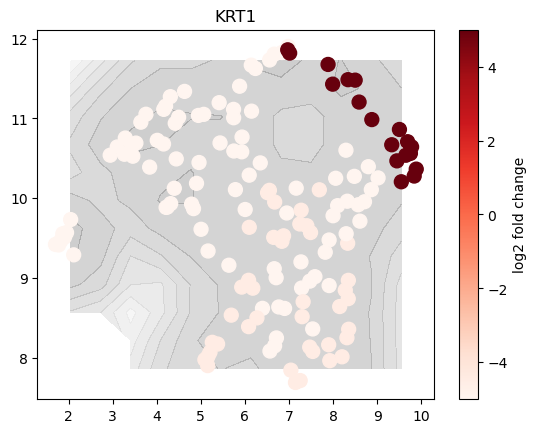

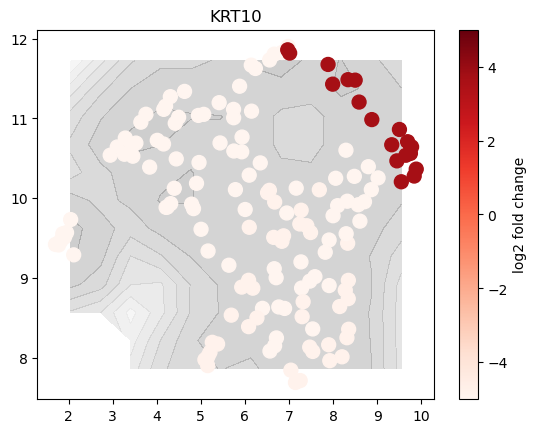

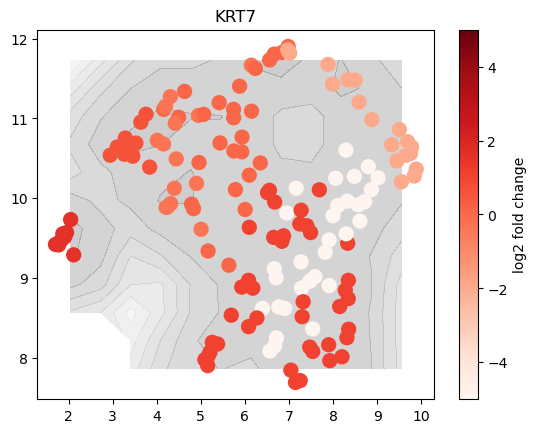

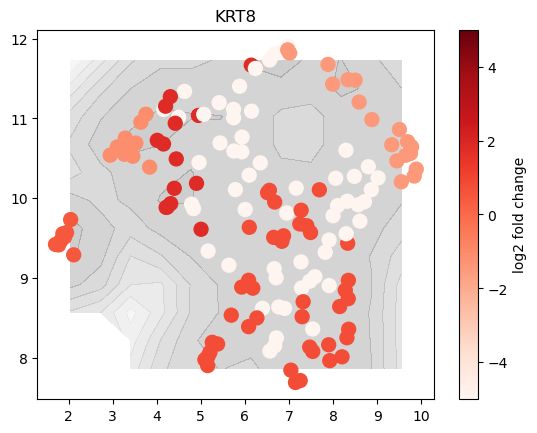

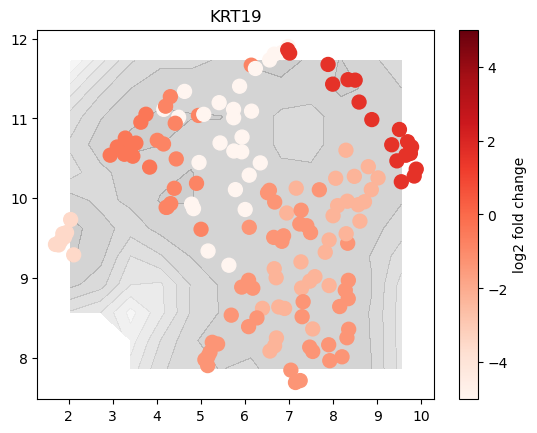

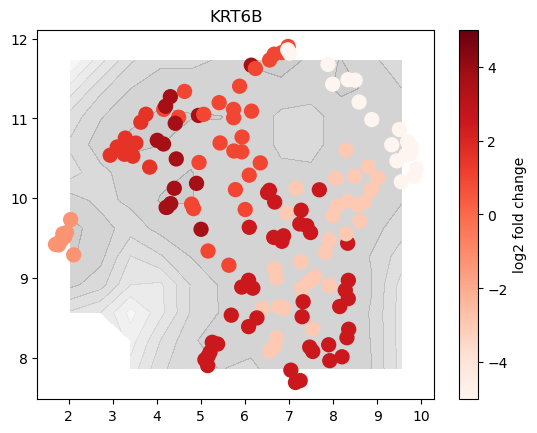

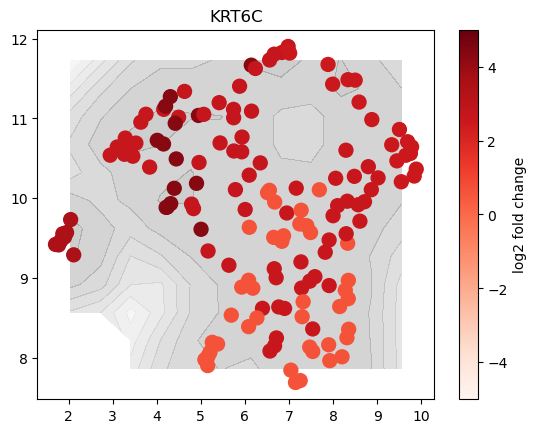

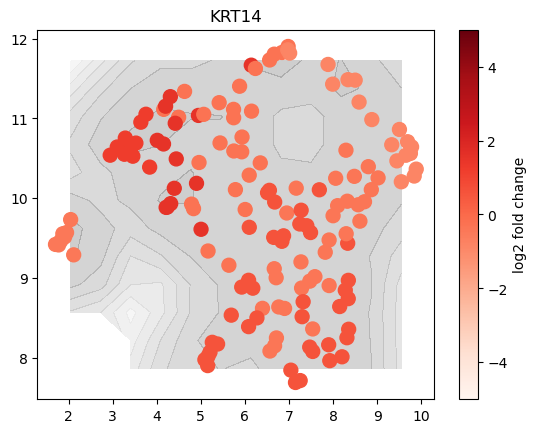

In [99]:
gnames=np.array(['KRT1','KRT10','KRT7','KRT17','KRT8','KRT18','KRT19','KRT5','KRT6A','KRT6B','KRT6C','KRT14','VIM'])
for iG in range(gnames.size):
    try:
        plt.figure()
        indg=np.where(gene_names==gnames[iG])[0][0]
        gene_lfc_states=np.log2(x_fc_states[:,indg])
        plt.contourf(xx,yy,-np.log(prob1.T),cmap=plt.cm.gray,alpha=0.2)
        plt.scatter(x_clusters[:,0],x_clusters[:,1],s=100,c=gene_lfc_states[stateSet],cmap=plt.cm.Reds,clim=(-5,5))
        plt.title(gnames[iG])
        cbar=plt.colorbar()
        cbar.set_label('log2 fold change')
    except:
        print(f'{gnames[iG]} not in most variable geneset')